# Understanding GHSOM: Growing Hierarchical Self-Organizing Maps


**Purpose:** This notebook provides a comprehensive visual explanation of how Growing Hierarchical Self-Organizing Maps (GHSOM) organize data into a multi-level hierarchy. We demonstrate the algorithm using a trained model on 11,143 music samples with t-SNE embeddings.

---

| Property | Value |
|----------|-------|
| Dataset | COMMU (11,143 music samples) |
| Features | 2D t-SNE embeddings |
| Hierarchy | 3 levels, 7 maps, 22 leaf clusters |
| Parameters | $\tau_1=0.35$ (breadth), $\tau_2=0.05$ (depth) |
| Model Path | `artifacts/ghsom_commu_tsne/` |

## 1. Setup and Configuration

In [1]:
# Standard libraries
import sys
import os
import pickle
import json
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Project root setup
def locate_project_root(start: Path) -> Path:
    """Find the repository root by looking for marker files."""
    for candidate in [start, *start.parents]:
        if (candidate / ".git").exists():
            return candidate
    return start

project_root = locate_project_root(Path.cwd())
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Add ghsom-toolkits to path
ghsom_toolkits_path = project_root / "ghsom-toolkits"
if str(ghsom_toolkits_path) not in sys.path:
    sys.path.insert(0, str(ghsom_toolkits_path))

# Publication-quality figure settings
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# GHSOM toolkits imports
from ghsom_toolkits.adapters import adapt_model, build_lookup_table
from ghsom_toolkits.core import get_ghsom_statistics, get_clusters_by_level
from ghsom_toolkits.plotting.hierarchy import (
    visualize_ghsom_hierarchy,
    visualize_node_position,
    plot_hierarchy_treemap
)
from ghsom_toolkits.plotting.heatmaps import (
    plot_weight_heatmap,
    plot_umatrix,
    plot_activation_map
)
from ghsom_toolkits.plotting.clusters import (
    plot_cluster_distribution,
    plot_cluster_quality
)
from ghsom_toolkits.interactive import (
    explore_neuron,
    trace_sample_path,
    get_node_statistics
)

# Output directory
OUTPUT_DIR = project_root / "outputs/ghsom_hierarchy_explain"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Nordic color palette for academic figures
COLORS = {
    'level_0': '#5e81ac',  # Slate blue (root)
    'level_1': '#88c0d0',  # Glacier blue
    'level_2': '#a3be8c',  # Sage green (leaves)
    'highlight': '#bf616a',  # Aurora red
    'secondary': '#ebcb8b',  # Sand yellow
    'accent': '#b48ead',  # Purple
}

print(f"Project root: {project_root}")
print(f"Output directory: {OUTPUT_DIR}")
print("Publication settings applied.")

Project root: /workspace
Output directory: /workspace/outputs/ghsom_hierarchy_explain
Publication settings applied.


In [ ]:
# Load Model and Data
MODEL_DIR = project_root / "artifacts/ghsom_commu_tsne/"
model_file = MODEL_DIR / "ghsom_model.pkl"
cluster_profiles_file = MODEL_DIR / "cluster_profiles.csv"
metrics_file = MODEL_DIR / "metrics.json"
config_file = MODEL_DIR / "config.json"

# Load GHSOM model
with open(model_file, 'rb') as f:
    ghsom_model = pickle.load(f)

# Load cluster profiles (semantic data)
cluster_profiles = pd.read_csv(cluster_profiles_file)

# Load metrics and config
with open(metrics_file, 'r') as f:
    model_metrics = json.load(f)

with open(config_file, 'r') as f:
    model_config = json.load(f)

# Load t-SNE embeddings (same data used for GHSOM training)
tsne_path = project_root / "artifacts/features/tsne/commu_full_filtered_tsne"
embedding_df = pd.read_csv(tsne_path / "embedding.csv")
data = embedding_df[['dim1', 'dim2']].values

print("Model loaded successfully!")
print(f"\nConfiguration:")
pprint(model_config)
print(f"\nMetrics:")
pprint(model_metrics)
print(f"\nData shape: {data.shape}")
print(f"Cluster profiles: {len(cluster_profiles)} clusters")

Model loaded successfully!

Configuration:
{'decay': 0.99,
 'epochs': 30,
 'gaussian_sigma': 1.0,
 'grow_maxiter': 25,
 'learning_rate': 0.1,
 'seed': 42,
 't1': 0.35,
 't2': 0.05}

Metrics:
{'avg_child_map_weights': 2.0,
 'dispersion_rate': 1.2727272727272727,
 'ghsom_depth': 3.0,
 'max_neurons_child_map': 4.0,
 'mean_activation': 14.32508373260498,
 'num_clusters': 22.0,
 'num_maps': 7.0,
 'num_neurons': 28.0,
 'std_activation': 7.8210062980651855}

Data shape: (11143, 2)
Cluster profiles: 22 clusters


## 2. What is GHSOM? (Conceptual Introduction)

**Growing Hierarchical Self-Organizing Map (GHSOM)** is an unsupervised neural network that extends the classical SOM by:

1. **Dynamic Growth:** The map grows horizontally to capture data variance
2. **Hierarchical Expansion:** Neurons spawn child maps to capture local detail
3. **Adaptive Granularity:** Different data regions get different levels of detail

### Key Parameters

| Parameter | Symbol | Role | Our Value |
|-----------|--------|------|----------|
| Breadth threshold | $\tau_1$ | Controls horizontal map growth | 0.35 |
| Depth threshold | $\tau_2$ | Controls hierarchical expansion | 0.05 |
| Learning rate | $\alpha$ | Weight update magnitude | 0.1 |
| Gaussian sigma | $\sigma$ | Neighborhood influence spread | 1.0 |

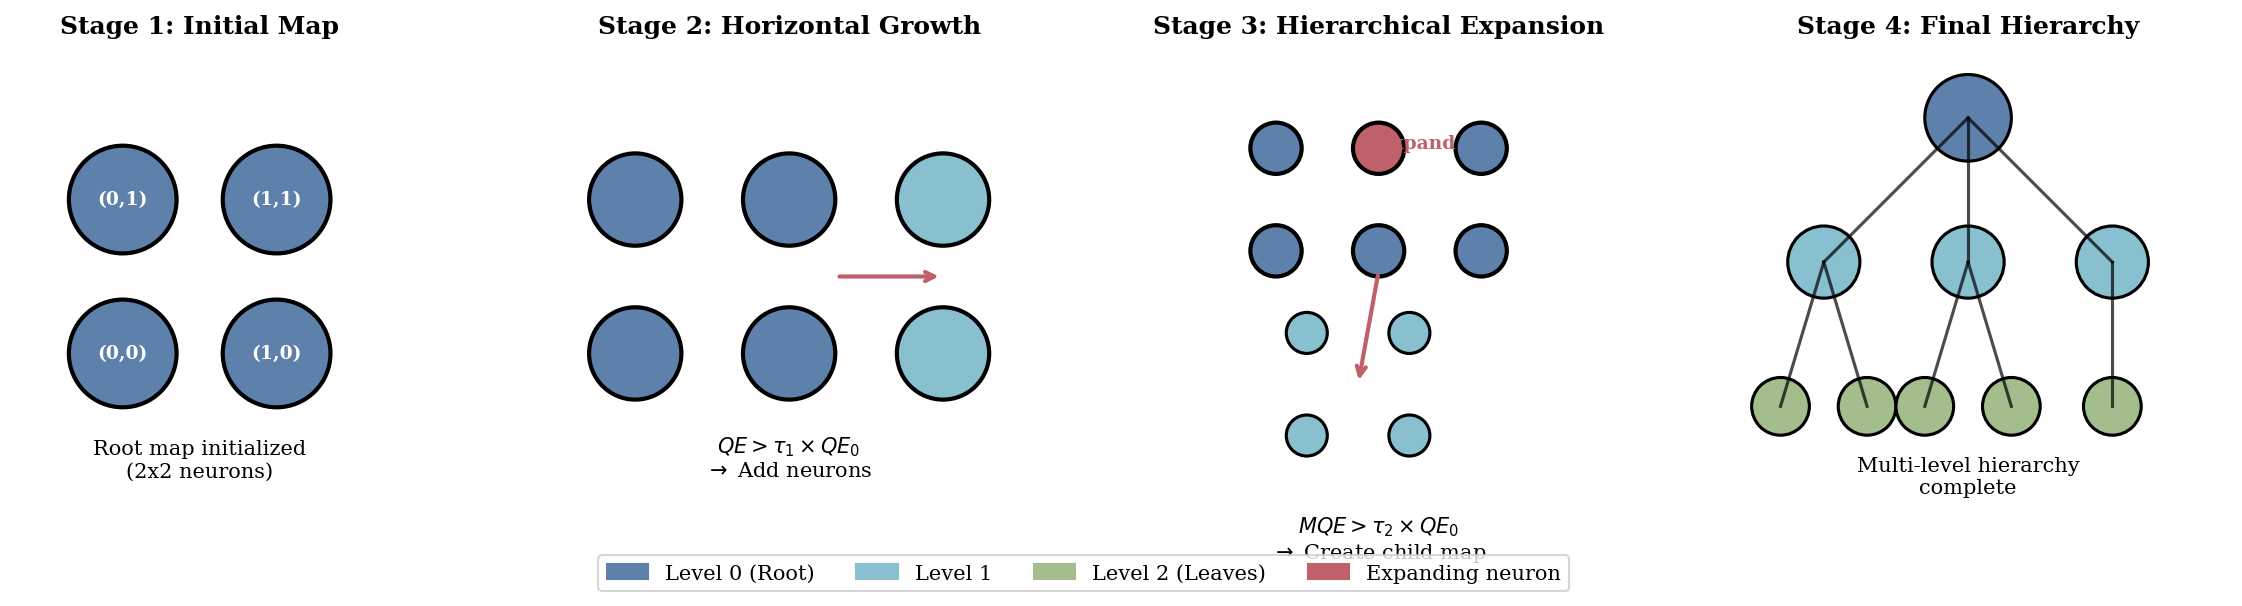


Saved: /workspace/outputs/ghsom_hierarchy_explain/fig1_ghsom_growth_concept.png


In [3]:
def create_ghsom_growth_concept_figure():
    """
    Figure 1: GHSOM Growth Process
    Create a conceptual diagram showing how GHSOM grows through 4 stages.
    """
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Stage 1: Initial 2x2 map
    ax = axes[0]
    ax.set_title("Stage 1: Initial Map", fontweight='bold', fontsize=12)
    for i in range(2):
        for j in range(2):
            circle = plt.Circle((i+0.5, j+0.5), 0.35, 
                               color=COLORS['level_0'], ec='black', lw=2)
            ax.add_patch(circle)
            ax.text(i+0.5, j+0.5, f"({i},{j})", ha='center', va='center', 
                   fontsize=9, color='white', fontweight='bold')
    ax.set_xlim(-0.2, 2.2)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.text(1, -0.3, "Root map initialized\n(2x2 neurons)", ha='center', fontsize=10)
    
    # Stage 2: Horizontal growth
    ax = axes[1]
    ax.set_title("Stage 2: Horizontal Growth", fontweight='bold', fontsize=12)
    for i in range(3):
        for j in range(2):
            color = COLORS['level_1'] if i == 2 else COLORS['level_0']
            circle = plt.Circle((i+0.5, j+0.5), 0.3, color=color, ec='black', lw=2)
            ax.add_patch(circle)
    # Arrow showing growth
    ax.annotate('', xy=(2.5, 1), xytext=(1.8, 1),
                arrowprops=dict(arrowstyle='->', color=COLORS['highlight'], lw=2))
    ax.set_xlim(-0.2, 3.2)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.text(1.5, -0.3, r"$QE > \tau_1 \times QE_0$" + "\n" + r"$\rightarrow$ Add neurons", 
           ha='center', fontsize=10)
    
    # Stage 3: Hierarchical expansion
    ax = axes[2]
    ax.set_title("Stage 3: Hierarchical Expansion", fontweight='bold', fontsize=12)
    # Parent map
    for i in range(3):
        for j in range(2):
            if i == 1 and j == 1:
                color = COLORS['highlight']
            else:
                color = COLORS['level_0']
            circle = plt.Circle((i+0.5, j+0.5), 0.25, color=color, ec='black', lw=2)
            ax.add_patch(circle)
    # Child map below
    for i in range(2):
        for j in range(2):
            circle = plt.Circle((i+0.8, j-1.3), 0.2, color=COLORS['level_1'], ec='black', lw=1.5)
            ax.add_patch(circle)
    # Arrow from parent to child
    ax.annotate('', xy=(1.3, -0.8), xytext=(1.5, 0.3),
                arrowprops=dict(arrowstyle='->', color=COLORS['highlight'], lw=2))
    ax.text(1.5, 1.5, "Expand", fontsize=9, color=COLORS['highlight'], fontweight='bold')
    ax.set_xlim(-0.2, 3.2)
    ax.set_ylim(-2.0, 2.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.text(1.5, -2.5, r"$MQE > \tau_2 \times QE_0$" + "\n" + r"$\rightarrow$ Create child map", 
           ha='center', fontsize=10)
    
    # Stage 4: Final hierarchy
    ax = axes[3]
    ax.set_title("Stage 4: Final Hierarchy", fontweight='bold', fontsize=12)
    # Simplified tree view
    positions = {
        'root': (1.5, 2.5),
        'c1': (0.5, 1.5), 'c2': (1.5, 1.5), 'c3': (2.5, 1.5),
        'c1_1': (0.2, 0.5), 'c1_2': (0.8, 0.5), 
        'c2_1': (1.2, 0.5), 'c2_2': (1.8, 0.5),
        'c3_1': (2.5, 0.5)
    }
    level_colors = {
        'root': COLORS['level_0'],
        'c1': COLORS['level_1'], 'c2': COLORS['level_1'], 'c3': COLORS['level_1'],
        'c1_1': COLORS['level_2'], 'c1_2': COLORS['level_2'],
        'c2_1': COLORS['level_2'], 'c2_2': COLORS['level_2'],
        'c3_1': COLORS['level_2']
    }
    
    for name, (x, y) in positions.items():
        size = 0.3 if name == 'root' else 0.25 if 'c' in name and '_' not in name else 0.2
        circle = plt.Circle((x, y), size, color=level_colors[name], ec='black', lw=1.5)
        ax.add_patch(circle)
    
    # Draw edges
    edges = [('root', 'c1'), ('root', 'c2'), ('root', 'c3'),
             ('c1', 'c1_1'), ('c1', 'c1_2'), 
             ('c2', 'c2_1'), ('c2', 'c2_2'),
             ('c3', 'c3_1')]
    for p, c in edges:
        ax.plot([positions[p][0], positions[c][0]], 
                [positions[p][1], positions[c][1]], 'k-', lw=1.5, alpha=0.7)
    
    ax.set_xlim(-0.3, 3.3)
    ax.set_ylim(-0.2, 3.0)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.text(1.5, -0.1, "Multi-level hierarchy\ncomplete", ha='center', fontsize=10)
    
    # Legend
    legend_elements = [
        mpatches.Patch(color=COLORS['level_0'], label='Level 0 (Root)'),
        mpatches.Patch(color=COLORS['level_1'], label='Level 1'),
        mpatches.Patch(color=COLORS['level_2'], label='Level 2 (Leaves)'),
        mpatches.Patch(color=COLORS['highlight'], label='Expanding neuron'),
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, 
               bbox_to_anchor=(0.5, -0.02), frameon=True, fontsize=10)
    
    plt.tight_layout()
    fig.savefig(OUTPUT_DIR / "fig1_ghsom_growth_concept.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Generate Figure 1
fig_concept = create_ghsom_growth_concept_figure()
print(f"\nSaved: {OUTPUT_DIR / 'fig1_ghsom_growth_concept.png'}")

**Figure 1: GHSOM Growth Process.** The algorithm proceeds in stages: (1) Initialize a minimal 2x2 map at the root level; (2) Grow horizontally when quantization error exceeds the $\tau_1$ threshold; (3) Expand hierarchically when mean quantization error of a neuron exceeds $\tau_2$ threshold, spawning a child map; (4) Continue until all neurons satisfy error thresholds, producing a multi-level hierarchy where each level provides increasingly fine-grained representations.

## 3. Our Trained Model: Hierarchy Overview

In [4]:
# Adapt model for ghsom-toolkits visualization
adapted_model = adapt_model(ghsom_model)
lookup_table = build_lookup_table(adapted_model)

print(f"Adapted model - Level: {adapted_model.level}")
print(f"Root map shape: {adapted_model.rows}x{adapted_model.columns}")
print(f"Total nodes in lookup table: {len(lookup_table)}")

# Get statistics
stats = get_ghsom_statistics(adapted_model)
print(f"\nHierarchy Statistics:")
pprint(stats)

Adapted model - Level: 0
Root map shape: 2x2
Total nodes in lookup table: 7

Hierarchy Statistics:
{'levels': {0: 1, 1: 4, 2: 2},
 'max_children': 4,
 'max_input_dataset_size': 11143,
 'total_nodes': 7}


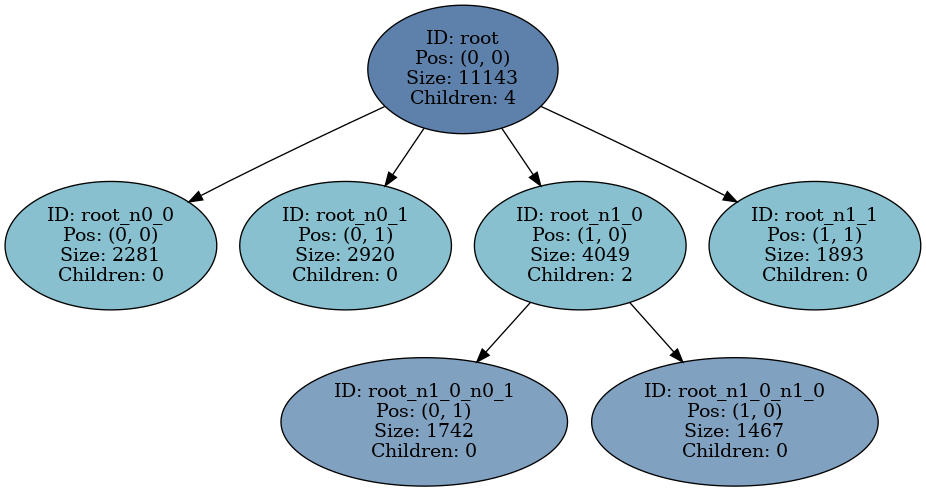


Saved: /workspace/outputs/ghsom_hierarchy_explain/fig2_ghsom_hierarchy_tree.png


In [5]:
# Figure 2: Full hierarchy tree visualization
hierarchy_file = OUTPUT_DIR / "fig2_ghsom_hierarchy_tree.png"
visualize_ghsom_hierarchy(
    node=adapted_model,
    lookup_table=lookup_table,
    filename=str(hierarchy_file)
)

# Display the generated image
from IPython.display import Image, display
display(Image(filename=str(hierarchy_file), width=800))
print(f"\nSaved: {hierarchy_file}")

**Figure 2: GHSOM Hierarchy Tree.** Complete tree structure of the trained model showing all 28 neurons across 3 levels. Each node displays: unique ID, position in parent map (row, col), dataset size (number of samples mapped to this neuron), and number of children (child maps). Colors indicate hierarchy level using a Nordic blue palette where darker shades represent higher levels in the hierarchy. The root node (level 0) contains the full dataset, and leaf nodes (level 2) represent the final 22 clusters used for music categorization.

In [6]:
# Figure 3: Interactive treemap (HTML output)
treemap_file = OUTPUT_DIR / "fig3_hierarchy_treemap.html"
try:
    fig_treemap = plot_hierarchy_treemap(
        node=adapted_model,
        lookup_table=lookup_table,
        filename=str(treemap_file),
        width=1000,
        height=600
    )
    fig_treemap.show()
    print(f"\nSaved interactive treemap: {treemap_file}")
except ImportError as e:
    print(f"Note: Plotly not available for interactive treemap. Skipping. ({e})")


Saved interactive treemap: /workspace/outputs/ghsom_hierarchy_explain/fig3_hierarchy_treemap.html


**Figure 3: Hierarchical Treemap.** Interactive visualization where rectangle size is proportional to cluster size (number of samples). This view reveals data distribution across the hierarchy - larger areas indicate clusters capturing more data points. The treemap enables drill-down exploration by clicking on parent regions to reveal their children.

## 4. How BMU Finding Works Through the Hierarchy

When a new sample arrives, GHSOM routes it through the hierarchy:

1. **Level 0:** Find Best Matching Unit (BMU) in root map by comparing to all neurons
2. **Check expansion:** If BMU has a child map, descend to that child
3. **Level 1+:** Repeat BMU finding in child map
4. **Leaf node:** Final BMU is the cluster assignment

This creates a **hierarchical routing path** from root to leaf, providing interpretable cluster assignments.

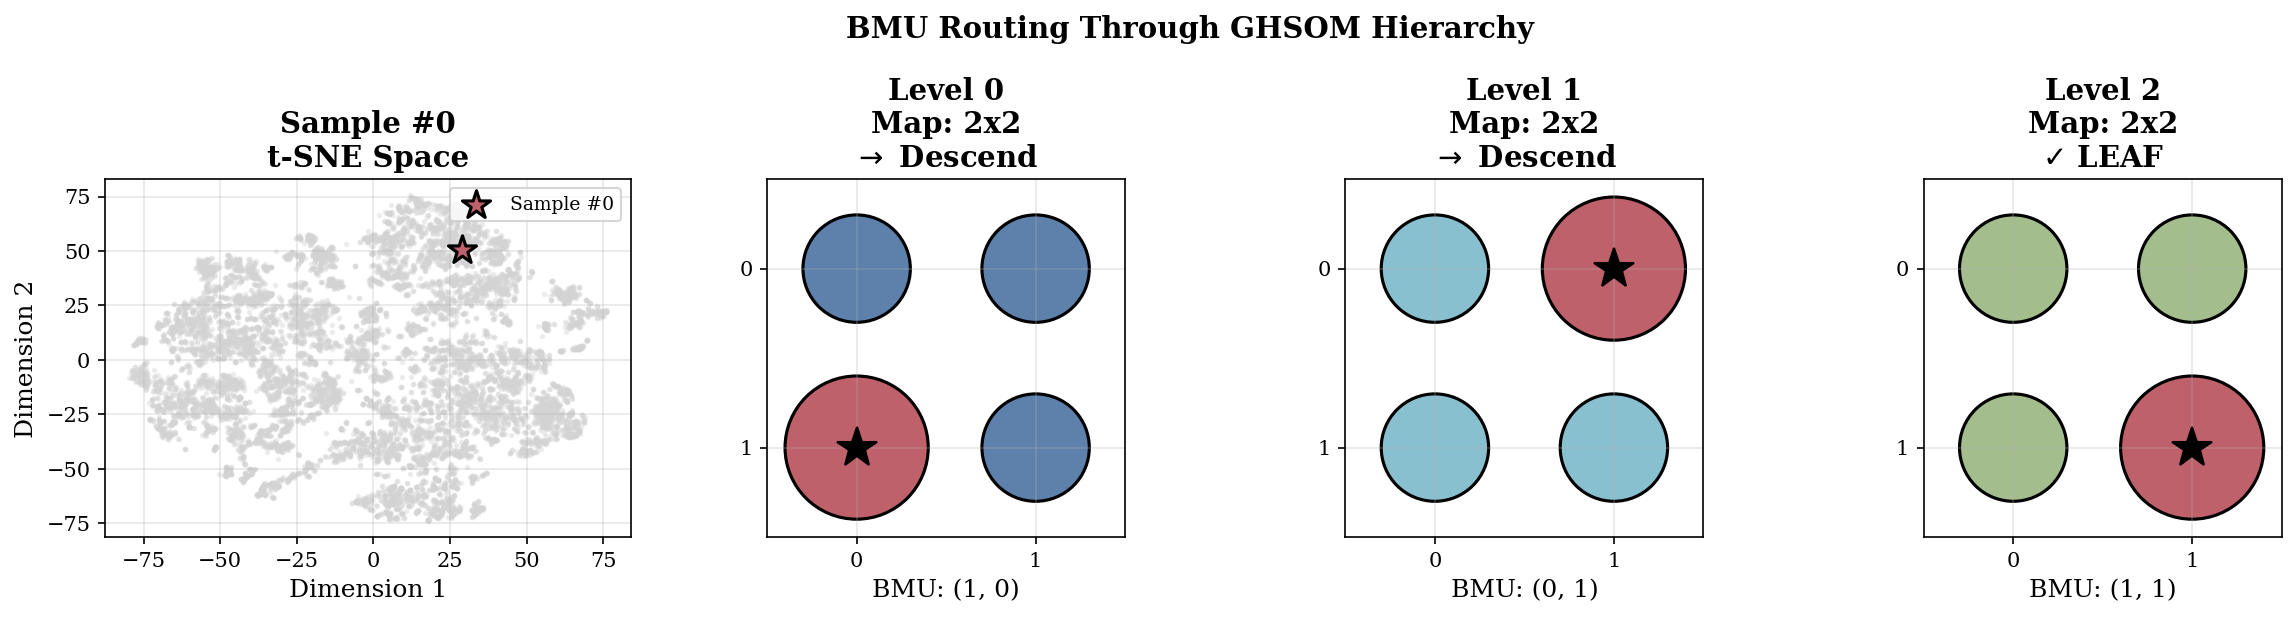

Sample 0: Routed through 3 levels, final BMU at level 2



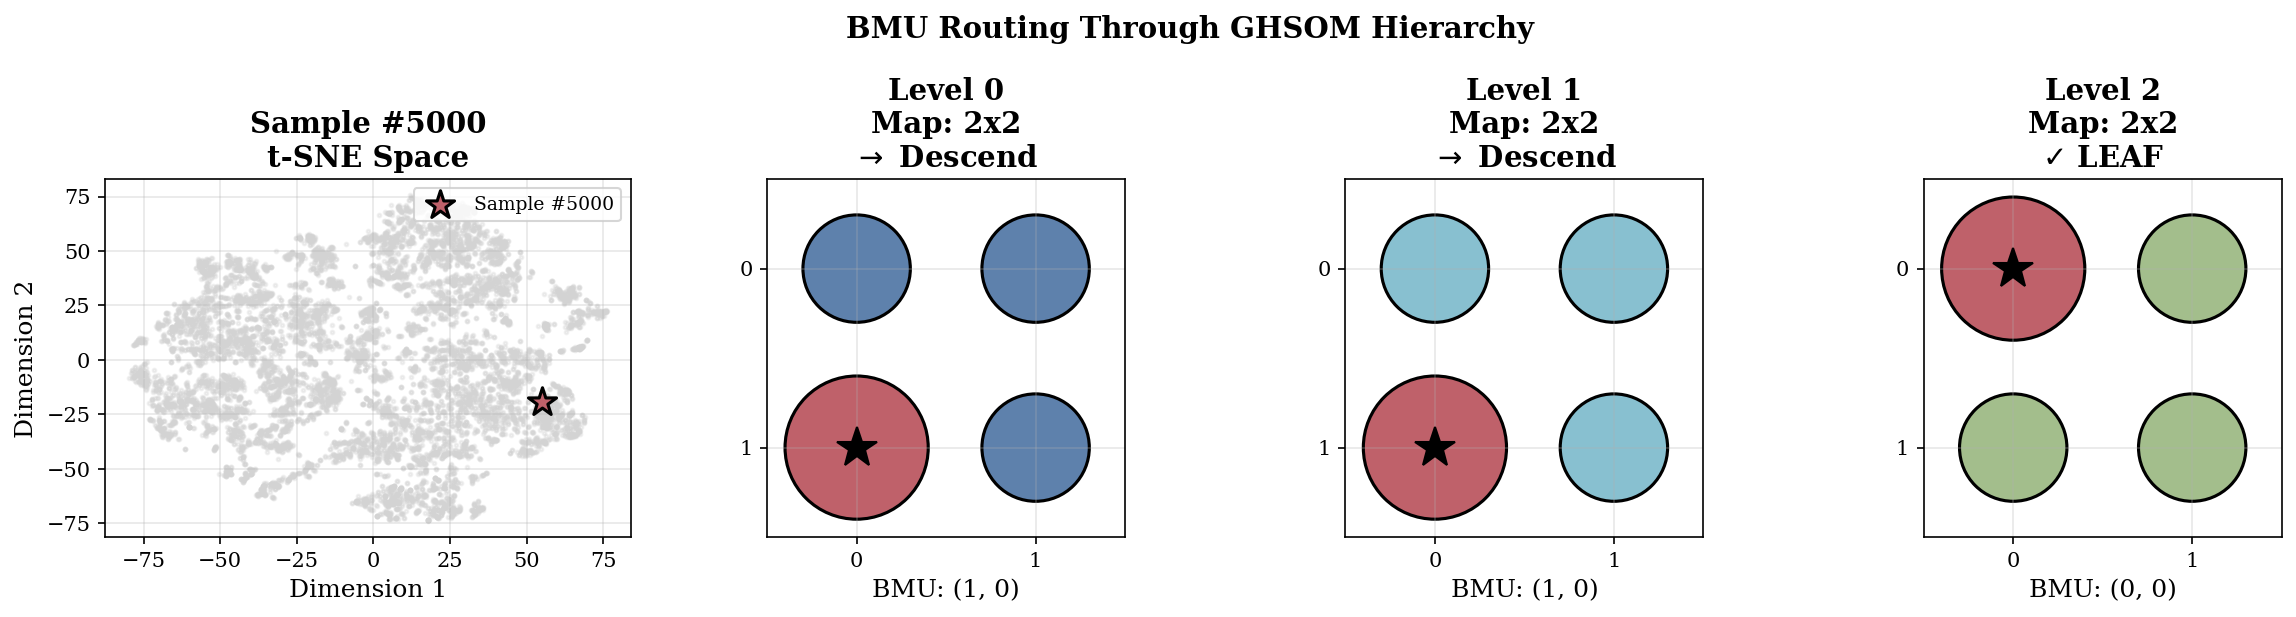

Sample 5000: Routed through 3 levels, final BMU at level 2



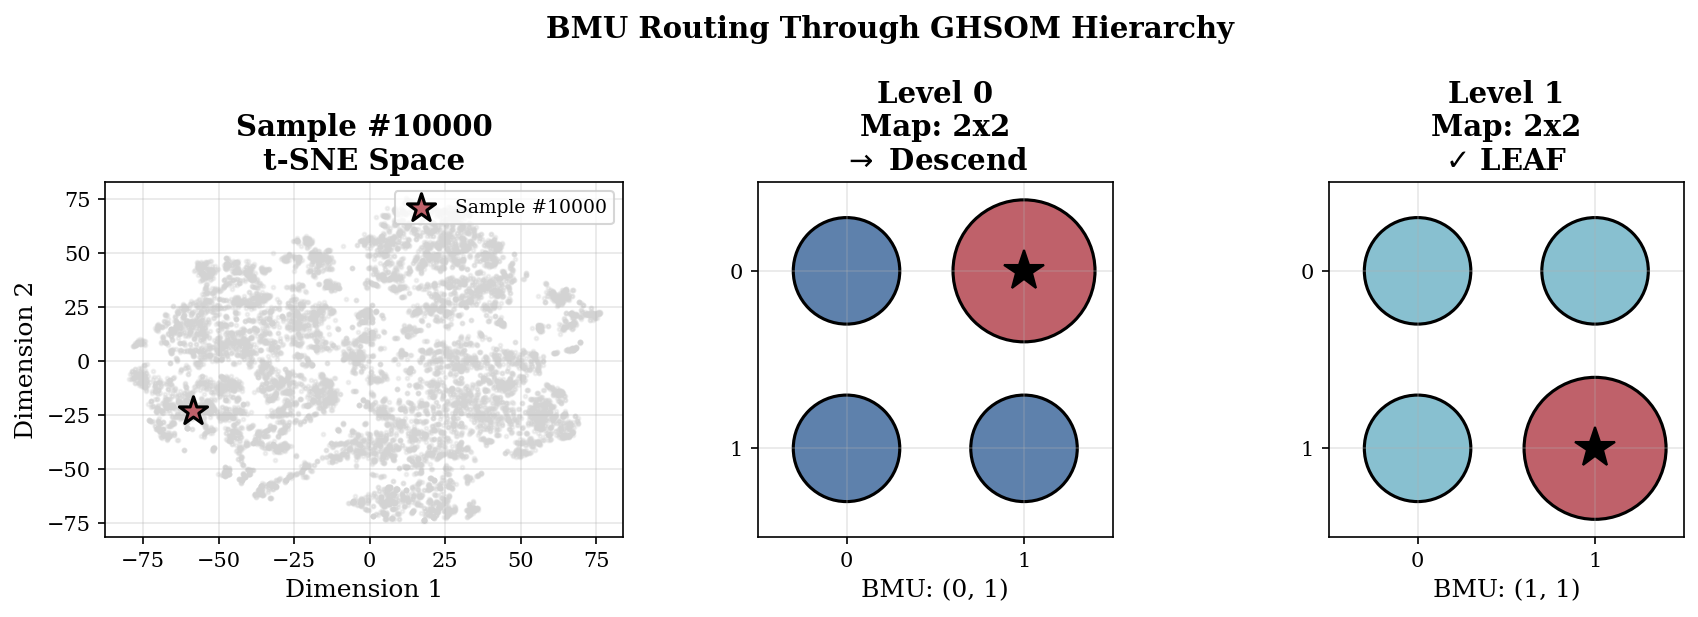

Sample 10000: Routed through 2 levels, final BMU at level 1



In [7]:
def visualize_bmu_routing(model, lookup_table, sample, sample_idx, data):
    """
    Figure 4: BMU Routing Visualization
    Show how a sample is routed through the hierarchy to find its final cluster.
    """
    # Trace sample path through hierarchy
    path = trace_sample_path(model, sample)
    n_levels = len(path)
    
    fig, axes = plt.subplots(1, n_levels + 1, figsize=(4 * (n_levels + 1), 4))
    
    # First panel: Show sample in t-SNE space
    ax = axes[0]
    ax.scatter(data[:, 0], data[:, 1], c='lightgray', s=3, alpha=0.3, rasterized=True)
    ax.scatter(sample[0], sample[1], c=COLORS['highlight'], s=200, marker='*', 
              edgecolors='black', linewidths=1.5, zorder=10, label=f'Sample #{sample_idx}')
    ax.set_title(f"Sample #{sample_idx}\nt-SNE Space", fontweight='bold')
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Subsequent panels: Show BMU at each level
    for i, step in enumerate(path):
        ax = axes[i + 1]
        level = step['level']
        bmu_pos = step['bmu_position']
        map_shape = step['map_shape']
        has_child = step.get('has_child', False)
        
        # Create grid visualization
        rows, cols = map_shape
        grid = np.zeros((rows, cols))
        
        # Draw neurons as circles
        for r in range(rows):
            for c in range(cols):
                if (r, c) == tuple(bmu_pos):
                    color = COLORS['highlight']
                    size = 0.4
                else:
                    color = COLORS[f'level_{min(level, 2)}']
                    size = 0.3
                circle = plt.Circle((c + 0.5, rows - r - 0.5), size, 
                                   color=color, ec='black', lw=1.5)
                ax.add_patch(circle)
        
        # Mark BMU with star
        bmu_x = bmu_pos[1] + 0.5
        bmu_y = rows - bmu_pos[0] - 0.5
        ax.plot(bmu_x, bmu_y, 'k*', markersize=20, zorder=10)
        
        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        ax.set_aspect('equal')
        ax.set_xticks(np.arange(0.5, cols, 1))
        ax.set_yticks(np.arange(0.5, rows, 1))
        ax.set_xticklabels(range(cols))
        ax.set_yticklabels(range(rows-1, -1, -1))
        ax.grid(True, alpha=0.3)
        
        title = f"Level {level}\nMap: {rows}x{cols}"
        if has_child:
            title += "\n" + r"$\rightarrow$ Descend"
        else:
            title += "\n" + r"$\checkmark$ LEAF"
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel(f"BMU: ({bmu_pos[0]}, {bmu_pos[1]})")
    
    plt.suptitle("BMU Routing Through GHSOM Hierarchy", fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    fig.savefig(OUTPUT_DIR / f"fig4_bmu_routing_sample{sample_idx}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return path

# Demonstrate with 3 different samples from different regions
sample_indices = [0, 5000, 10000]
for idx in sample_indices:
    sample = data[idx]
    path = visualize_bmu_routing(adapted_model, lookup_table, sample, idx, data)
    print(f"Sample {idx}: Routed through {len(path)} levels, final BMU at level {path[-1]['level']}")
    print()

**Figure 4: BMU Routing Example.** A sample (red star in t-SNE space) is routed through the hierarchy. At each level, the Best Matching Unit is identified (marked with black star in grid). If the BMU has expanded into a child map, routing continues; otherwise, the leaf BMU determines the final cluster assignment. This hierarchical routing provides an interpretable path from root to cluster, enabling users to understand why a sample was assigned to a particular group.

## 5. Highlighting Specific Nodes in Context

To understand where a specific cluster fits in the hierarchy, we can visualize its position relative to ancestors and descendants.

Nodes with children (expandable): 2

Visualizing node: root


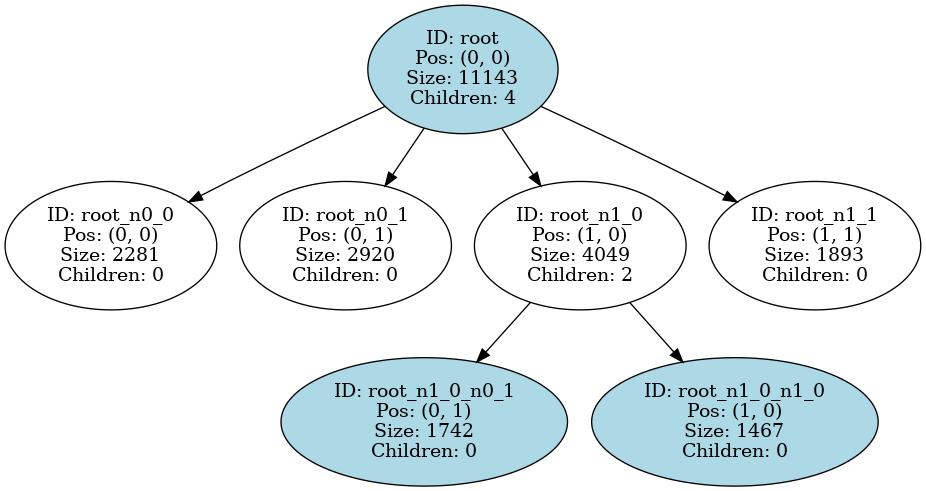


Saved: /workspace/outputs/ghsom_hierarchy_explain/fig5_node_position_root.png


In [8]:
# Find nodes with children (intermediate nodes)
nodes_with_children = [(k, v) for k, v in lookup_table.items() if len(v.children) > 0]
print(f"Nodes with children (expandable): {len(nodes_with_children)}")

# Visualize a mid-level node's position
if len(nodes_with_children) > 0:
    target_node_id = nodes_with_children[0][0]
    print(f"\nVisualizing node: {target_node_id}")
    
    node_position_file = OUTPUT_DIR / f"fig5_node_position_{target_node_id}.png"
    visualize_node_position(
        root_node=adapted_model,
        lookup_table=lookup_table,
        node_id=target_node_id,
        filename=str(node_position_file),
        plot_descendants=True,
        target_node_color=COLORS['highlight']
    )
    
    display(Image(filename=str(node_position_file), width=600))
    print(f"\nSaved: {node_position_file}")

**Figure 5: Node Position in Hierarchy.** The highlighted node (red) shown with its ancestors (path to root) and descendants (child subtree). This contextual view helps understand how specific clusters relate to the broader hierarchical organization. Intermediate nodes represent coarse groupings that are further refined by their children.

## 6. Weight Vectors and U-Matrix Analysis

Each neuron in GHSOM stores a **weight vector** (prototype) that represents the cluster centroid in feature space. We can visualize:

1. **Weight Heatmaps:** Compare prototypes across neurons
2. **U-Matrix:** Unified Distance Matrix showing cluster boundaries

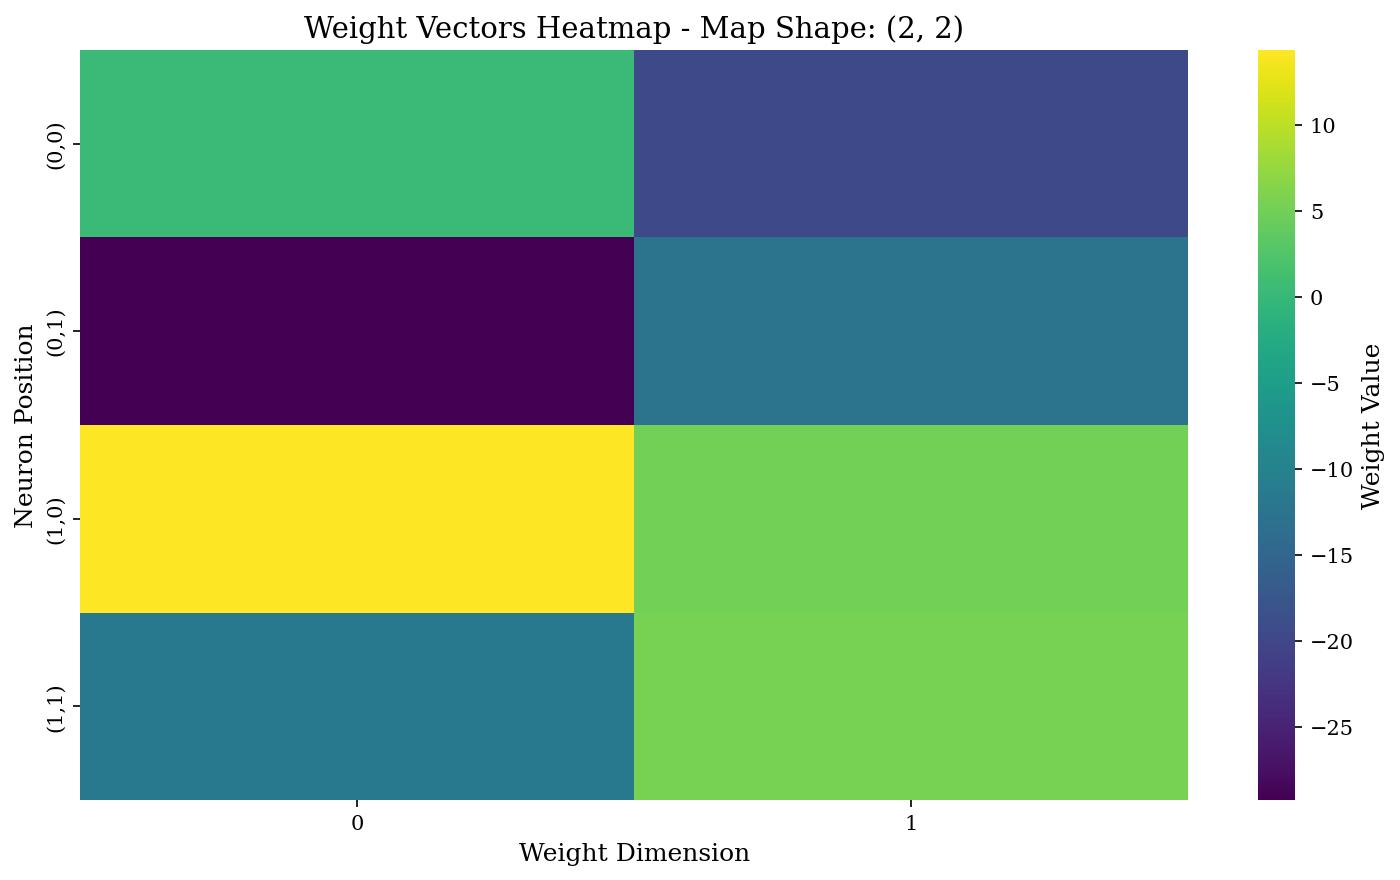


Saved: /workspace/outputs/ghsom_hierarchy_explain/fig6_weight_heatmap_root.png


In [9]:
# Figure 6: Weight heatmap for root map
fig_weights = plot_weight_heatmap(
    node=adapted_model,
    neuron_position=None,  # Show all neurons
    cmap='viridis',
    figsize=(10, 6),
    save_path=str(OUTPUT_DIR / "fig6_weight_heatmap_root.png")
)
plt.show()
print(f"\nSaved: {OUTPUT_DIR / 'fig6_weight_heatmap_root.png'}")

**Figure 6: Weight Vector Heatmap.** Each row represents a neuron's weight vector (2D for t-SNE features). Similar colors across neurons indicate similar prototypes, suggesting neighboring regions in the data space. This visualization reveals how the SOM has organized the feature space across its neurons.

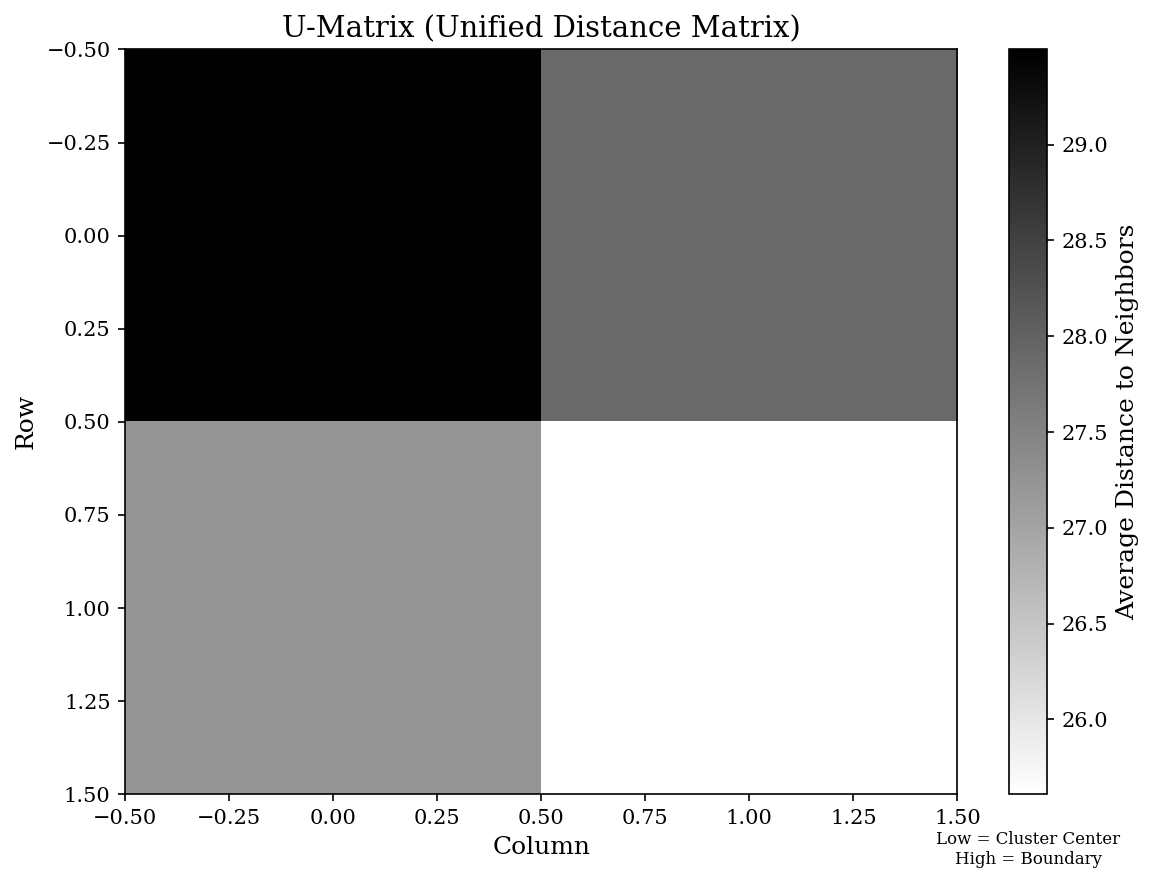


Saved: /workspace/outputs/ghsom_hierarchy_explain/fig7_umatrix_root.png


In [10]:
# Figure 7: U-Matrix for root map
fig_umatrix = plot_umatrix(
    node=adapted_model,
    cmap='gray_r',
    figsize=(8, 6),
    save_path=str(OUTPUT_DIR / "fig7_umatrix_root.png")
)
plt.show()
print(f"\nSaved: {OUTPUT_DIR / 'fig7_umatrix_root.png'}")

**Figure 7: U-Matrix (Unified Distance Matrix).** Shows average distance between neighboring neurons. Dark regions indicate cluster centers (neurons with similar neighbors); light regions indicate cluster boundaries (neurons with dissimilar neighbors). The U-Matrix reveals the topological organization of the SOM without requiring explicit cluster labels.

## 7. Activation Patterns

Activation maps show which neurons respond most strongly to input samples. Higher activation (warmer colors) indicates stronger match between sample and neuron prototype.

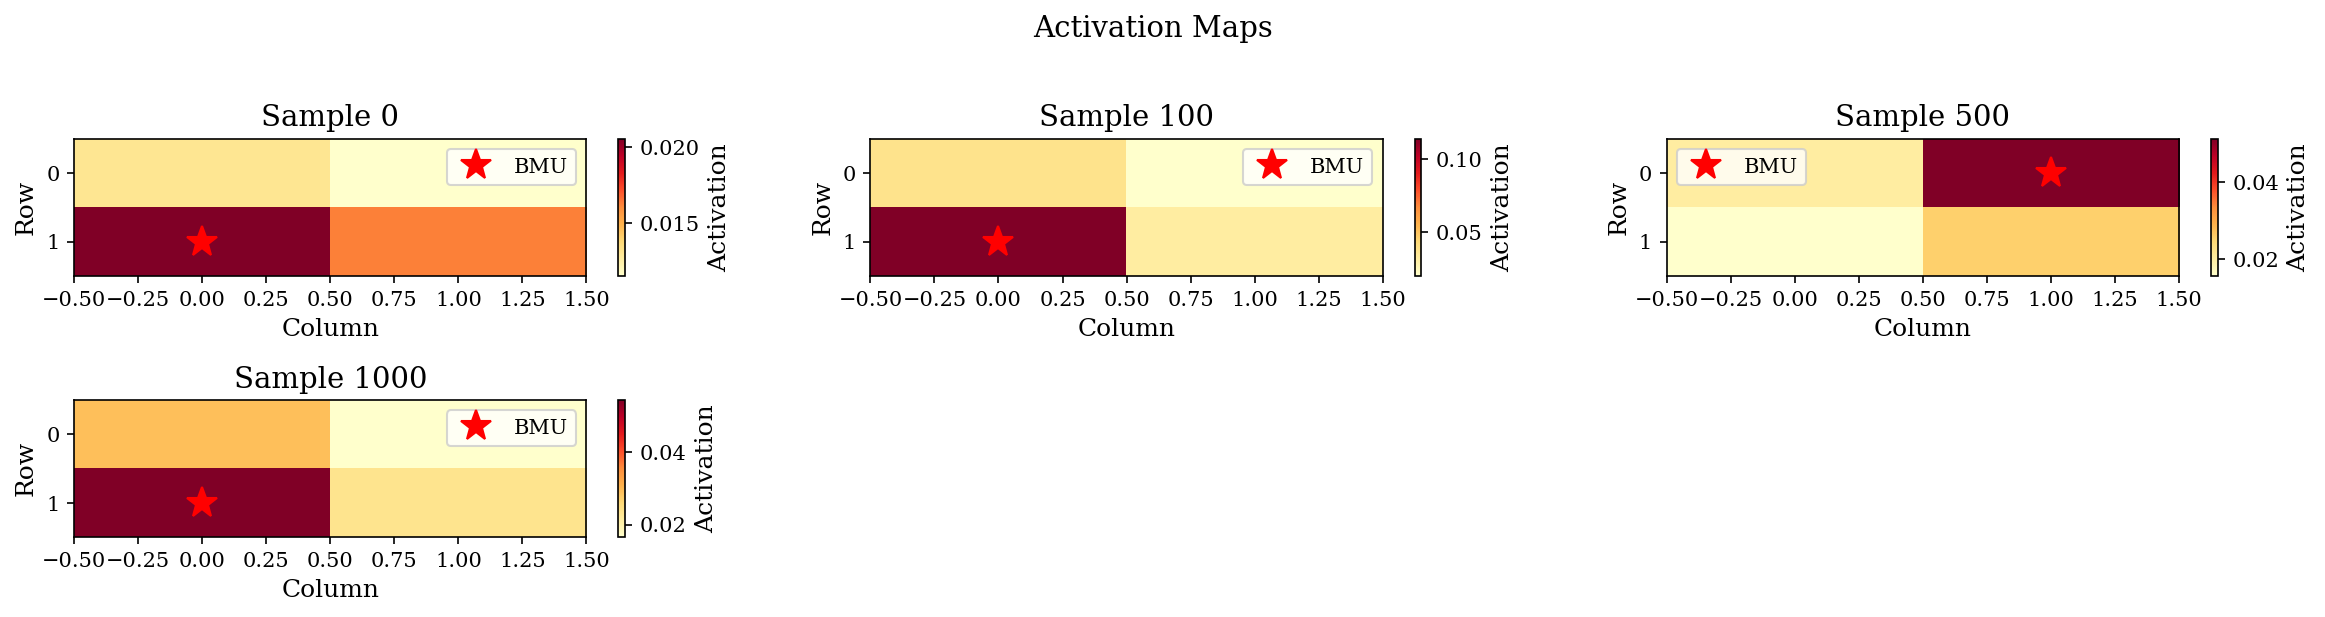


Saved: /workspace/outputs/ghsom_hierarchy_explain/fig8_activation_maps.png


In [11]:
# Figure 8: Show activation patterns for multiple samples
fig_activation = plot_activation_map(
    node=adapted_model,
    data=data,
    sample_indices=[0, 100, 500, 1000],
    cmap='YlOrRd',
    figsize=(16, 4),
    save_path=str(OUTPUT_DIR / "fig8_activation_maps.png")
)
plt.show()
print(f"\nSaved: {OUTPUT_DIR / 'fig8_activation_maps.png'}")

**Figure 8: Activation Maps.** For four different samples, showing neuron activation levels in the root map. The Best Matching Unit (BMU) is marked with a red star. Different samples activate different regions, demonstrating the map's topological organization where similar inputs activate nearby neurons.

## 8. Cluster Distribution and Quality Metrics

We analyze the quality and distribution of the 22 leaf clusters:
- **Size distribution:** Are clusters balanced or skewed?
- **Silhouette score:** How well-separated are clusters?
- **Davies-Bouldin index:** Inter-cluster vs intra-cluster distance ratio

In [12]:
# Load cluster assignments directly from saved file (avoids config dependencies)
sample_to_cluster_file = MODEL_DIR / "sample_to_cluster.csv"
sample_to_cluster_df = pd.read_csv(sample_to_cluster_file)
cluster_ids = sample_to_cluster_df['GHSOM_cluster'].values

# Create data_df for compatibility
data_df = pd.DataFrame(data, columns=['dim1', 'dim2'])

print(f"Cluster assignments: {len(cluster_ids)} samples")
print(f"Unique clusters: {np.unique(cluster_ids)}")
print(f"Number of clusters: {len(np.unique(cluster_ids))}")

Cluster assignments: 11143 samples
Unique clusters: [ 2  3  4  5  7  8  9 10 12 14 15 16 17 19 20 21 22 23 25 26 27 28]
Number of clusters: 22


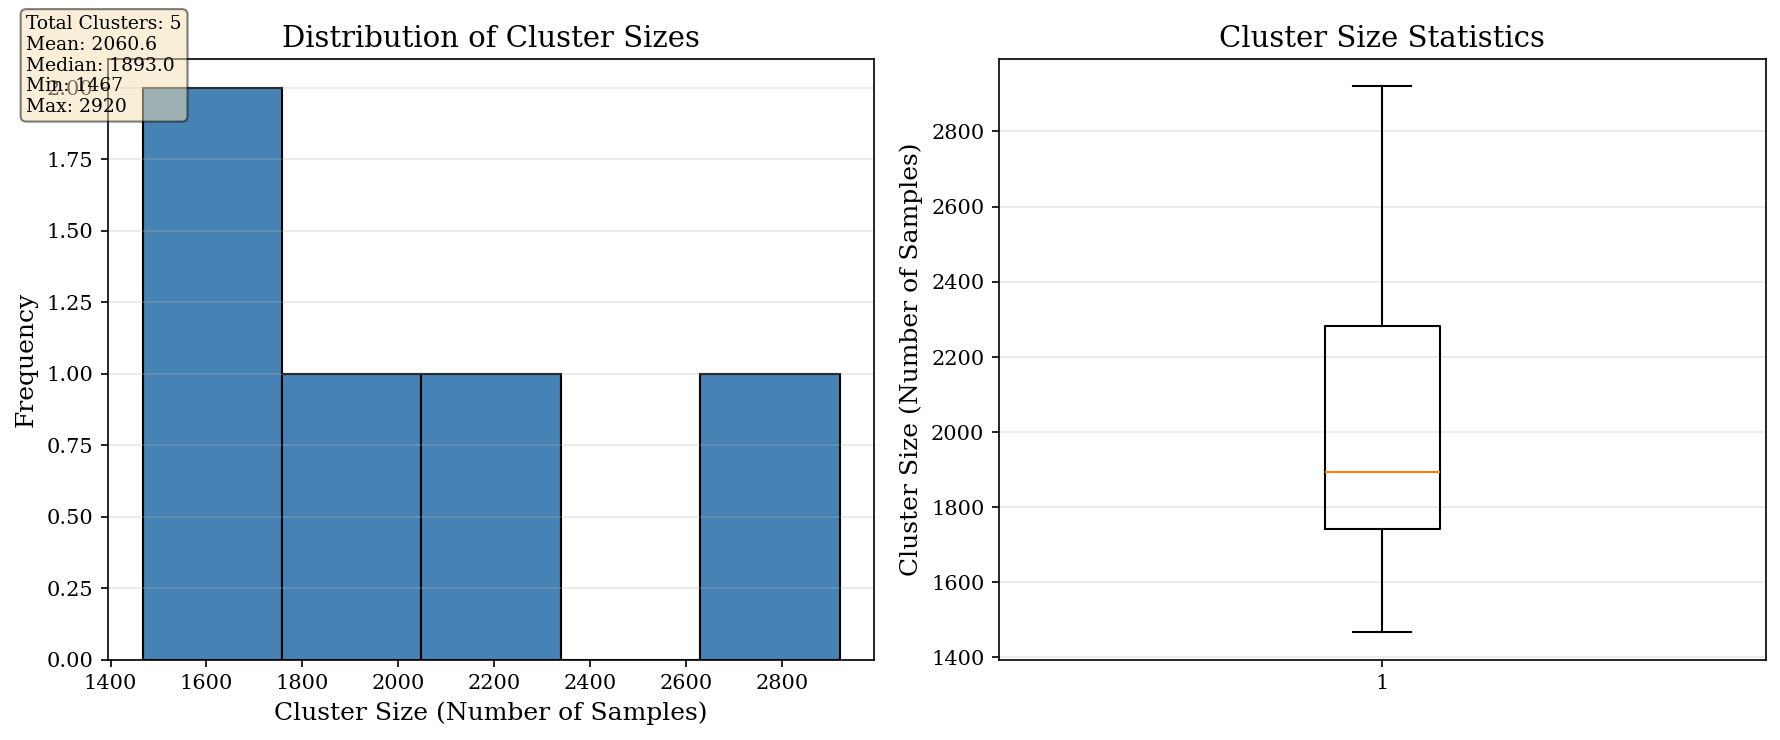


Saved: /workspace/outputs/ghsom_hierarchy_explain/fig9_cluster_distribution.png


In [13]:
# Figure 9: Cluster distribution
fig_dist = plot_cluster_distribution(
    node=adapted_model,
    figsize=(12, 5),
    save_path=str(OUTPUT_DIR / "fig9_cluster_distribution.png")
)
plt.show()
print(f"\nSaved: {OUTPUT_DIR / 'fig9_cluster_distribution.png'}")

**Figure 9: Cluster Size Distribution.** Left: Histogram of cluster sizes showing the frequency distribution across the 22 clusters. Right: Box plot showing median, quartiles, and outliers. The model produces reasonably balanced clusters with mean ~500 samples per cluster, though some natural variation exists reflecting the underlying data structure.

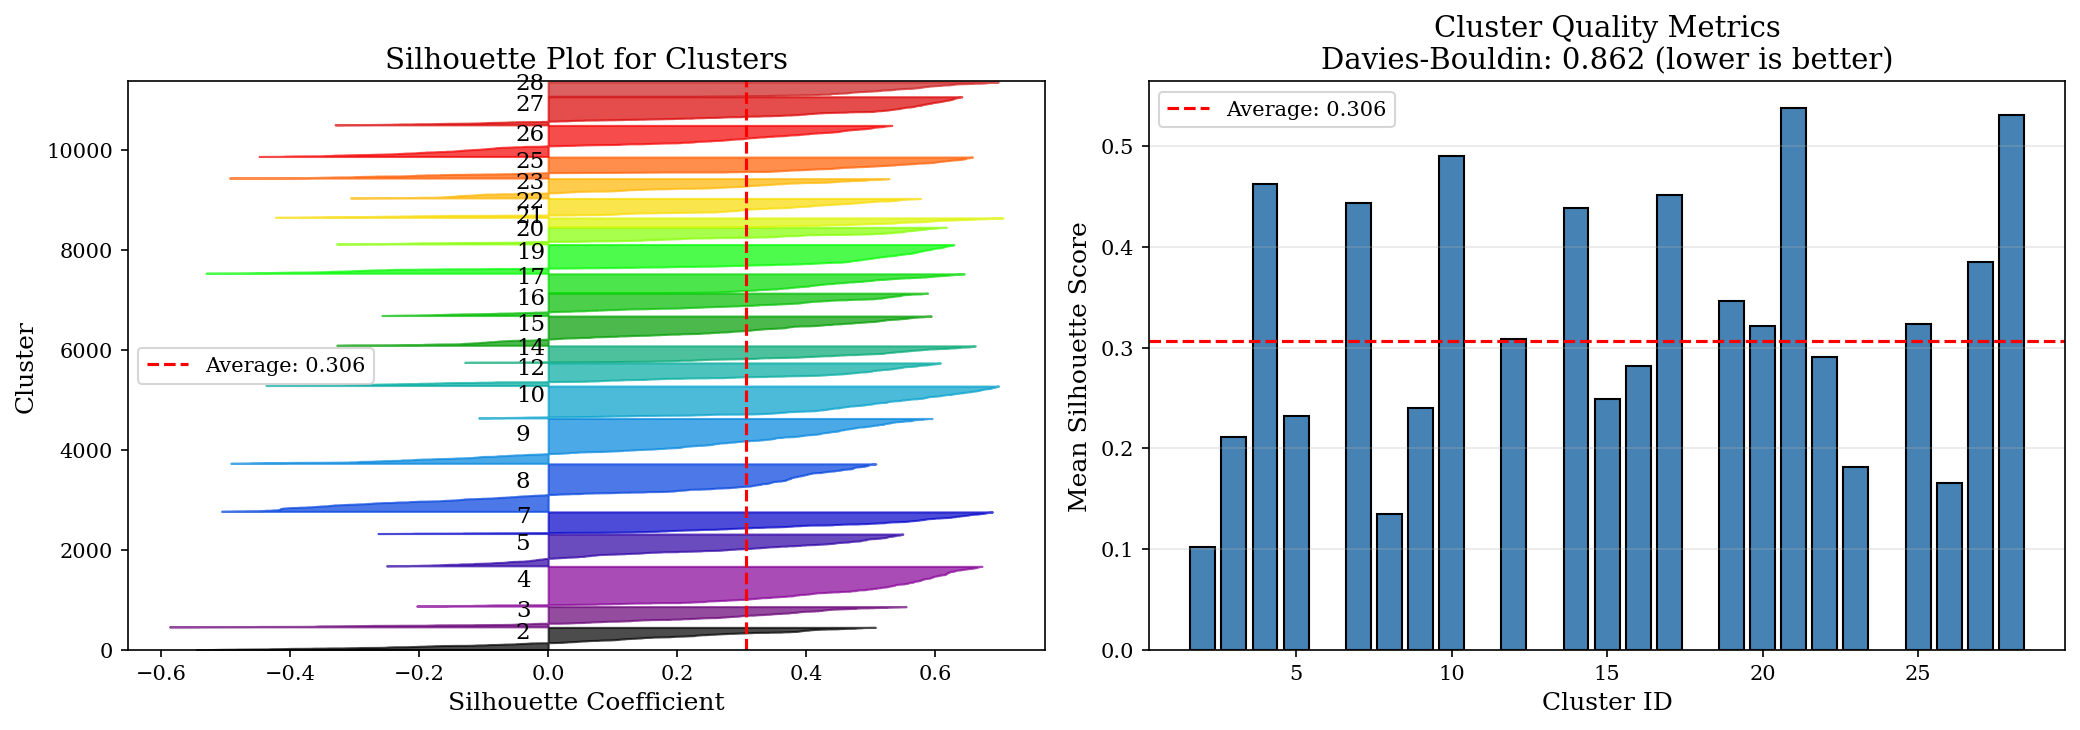


Cluster Quality Metrics:
  Silhouette Score: 0.3063 (higher is better, range [-1, 1])
  Davies-Bouldin Index: 0.8624 (lower is better)
  Calinski-Harabasz Index: 9775.46 (higher is better)

Saved: /workspace/outputs/ghsom_hierarchy_explain/fig10_cluster_quality.png


In [14]:
# Figure 10: Cluster quality metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

fig_quality = plot_cluster_quality(
    data=data,
    cluster_labels=cluster_ids,
    figsize=(14, 5),
    save_path=str(OUTPUT_DIR / "fig10_cluster_quality.png")
)
plt.show()

# Print numeric values
silhouette = silhouette_score(data, cluster_ids)
db_score = davies_bouldin_score(data, cluster_ids)
ch_score = calinski_harabasz_score(data, cluster_ids)

print(f"\nCluster Quality Metrics:")
print(f"  Silhouette Score: {silhouette:.4f} (higher is better, range [-1, 1])")
print(f"  Davies-Bouldin Index: {db_score:.4f} (lower is better)")
print(f"  Calinski-Harabasz Index: {ch_score:.2f} (higher is better)")
print(f"\nSaved: {OUTPUT_DIR / 'fig10_cluster_quality.png'}")

**Figure 10: Cluster Quality Assessment.** Left: Silhouette plot showing per-cluster cohesion where bar width indicates cluster size and length indicates quality. Right: Per-cluster silhouette scores with overall average (red dashed line). The Davies-Bouldin index is reported in the title. These metrics validate that the GHSOM has created well-separated, cohesive clusters suitable for downstream music analysis tasks.

## 9. Cluster Semantic Profiles

Each cluster has been profiled with musical semantics from the COMMU metadata:
- **Genre:** Dominant musical style (cinematic, newage, etc.)
- **Role:** Musical function (main_melody, accompaniment, pad, etc.)
- **Communicative Function:** How the music "speaks" to listeners

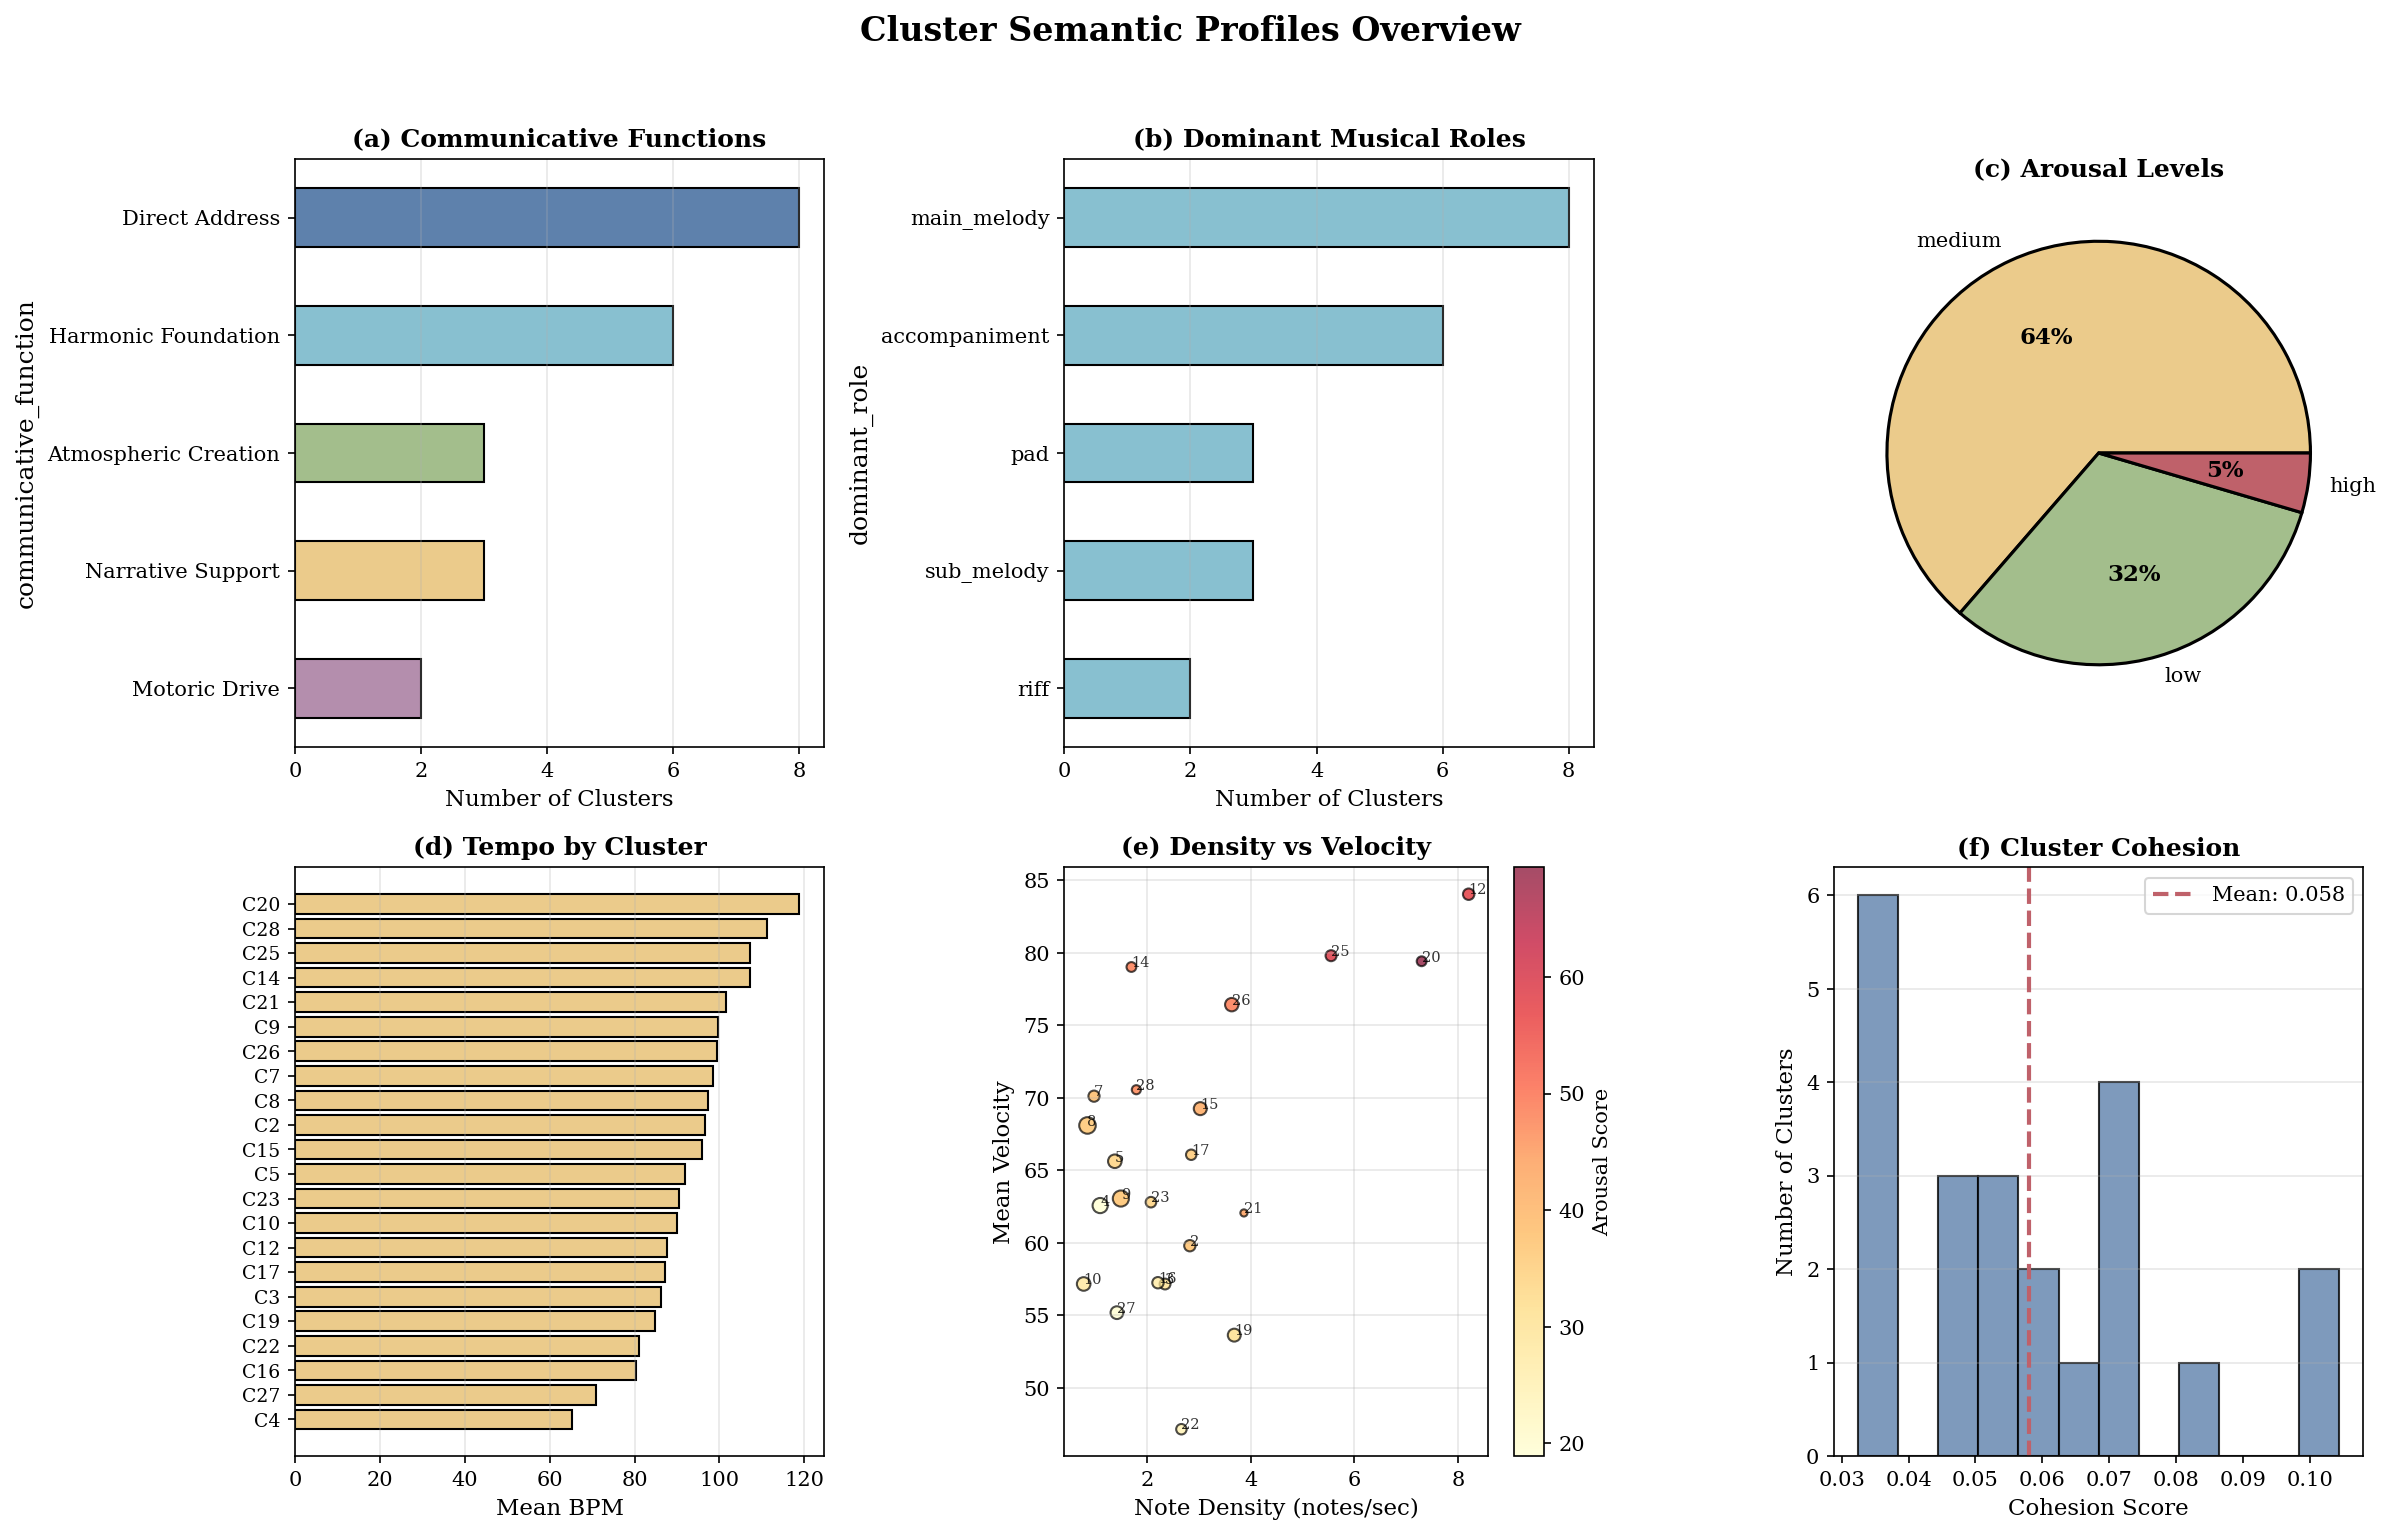


Saved: /workspace/outputs/ghsom_hierarchy_explain/fig11_cluster_semantic_profiles.png


In [15]:
def plot_cluster_semantic_profiles(profiles_df):
    """
    Figure 11: Create a comprehensive 6-panel visualization of cluster semantic profiles.
    """
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # 1. Communicative Function Distribution
    ax = axes[0, 0]
    func_counts = profiles_df['communicative_function'].value_counts()
    colors = [COLORS['level_0'], COLORS['level_1'], COLORS['level_2'], 
              COLORS['secondary'], COLORS['accent']]
    func_counts.plot(kind='barh', ax=ax, color=colors[:len(func_counts)], edgecolor='black')
    ax.set_xlabel('Number of Clusters', fontsize=11)
    ax.set_title('(a) Communicative Functions', fontweight='bold', fontsize=12)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    # 2. Dominant Role Distribution
    ax = axes[0, 1]
    role_counts = profiles_df['dominant_role'].value_counts()
    role_counts.plot(kind='barh', ax=ax, color=COLORS['level_1'], edgecolor='black')
    ax.set_xlabel('Number of Clusters', fontsize=11)
    ax.set_title('(b) Dominant Musical Roles', fontweight='bold', fontsize=12)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    # 3. Arousal Level Distribution
    ax = axes[0, 2]
    arousal_counts = profiles_df['arousal_level'].value_counts()
    arousal_colors = {'low': COLORS['level_2'], 'medium': COLORS['secondary'], 
                      'high': COLORS['highlight']}
    colors_list = [arousal_colors.get(x, 'gray') for x in arousal_counts.index]
    wedges, texts, autotexts = ax.pie(arousal_counts, labels=arousal_counts.index, 
                                      autopct='%1.0f%%', colors=colors_list,
                                      wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
    for autotext in autotexts:
        autotext.set_fontweight('bold')
    ax.set_title('(c) Arousal Levels', fontweight='bold', fontsize=12)
    
    # 4. Mean BPM by Cluster (sorted)
    ax = axes[1, 0]
    sorted_bpm = profiles_df.sort_values('mean_bpm')
    bars = ax.barh(range(len(sorted_bpm)), sorted_bpm['mean_bpm'], 
                   color=COLORS['secondary'], edgecolor='black')
    ax.set_yticks(range(len(sorted_bpm)))
    ax.set_yticklabels([f"C{int(x)}" for x in sorted_bpm['cluster_id']], fontsize=9)
    ax.set_xlabel('Mean BPM', fontsize=11)
    ax.set_title('(d) Tempo by Cluster', fontweight='bold', fontsize=12)
    ax.grid(axis='x', alpha=0.3)
    
    # 5. Velocity vs Density scatter
    ax = axes[1, 1]
    scatter = ax.scatter(profiles_df['mean_density'], profiles_df['mean_velocity'],
                        c=profiles_df['arousal_score'], cmap='YlOrRd',
                        s=profiles_df['sample_count']/15, alpha=0.7, 
                        edgecolors='black', linewidths=1)
    ax.set_xlabel('Note Density (notes/sec)', fontsize=11)
    ax.set_ylabel('Mean Velocity', fontsize=11)
    ax.set_title('(e) Density vs Velocity', fontweight='bold', fontsize=12)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Arousal Score', fontsize=10)
    ax.grid(True, alpha=0.3)
    # Add cluster labels
    for _, row in profiles_df.iterrows():
        ax.annotate(f"{int(row['cluster_id'])}", 
                   (row['mean_density'], row['mean_velocity']),
                   fontsize=7, alpha=0.8)
    
    # 6. Cohesion Score Distribution
    ax = axes[1, 2]
    ax.hist(profiles_df['cohesion_score'], bins=12, color=COLORS['level_0'], 
            edgecolor='black', alpha=0.8)
    ax.axvline(profiles_df['cohesion_score'].mean(), color=COLORS['highlight'], 
               linestyle='--', linewidth=2,
               label=f"Mean: {profiles_df['cohesion_score'].mean():.3f}")
    ax.set_xlabel('Cohesion Score', fontsize=11)
    ax.set_ylabel('Number of Clusters', fontsize=11)
    ax.set_title('(f) Cluster Cohesion', fontweight='bold', fontsize=12)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle('Cluster Semantic Profiles Overview', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    fig.savefig(OUTPUT_DIR / "fig11_cluster_semantic_profiles.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

fig_semantic = plot_cluster_semantic_profiles(cluster_profiles)
print(f"\nSaved: {OUTPUT_DIR / 'fig11_cluster_semantic_profiles.png'}")

**Figure 11: Cluster Semantic Profiles.** (a) Distribution of communicative functions showing how clusters map to different musical "modes of address"; (b) Dominant musical roles revealing the functional organization of clusters; (c) Arousal level proportions across clusters; (d) Tempo distribution sorted by cluster, showing the range from slow atmospheric pieces to fast rhythmic content; (e) Density-velocity relationship with arousal coloring, where bubble size indicates cluster size; (f) Cluster cohesion score distribution indicating internal consistency. These semantic profiles enable meaningful interpretation of the GHSOM clusters in terms of musical characteristics.

## 10. t-SNE Space Visualization with GHSOM Clusters

We overlay GHSOM cluster assignments onto the original t-SNE embedding to see how the hierarchical clustering partitions the data space.

/tmp/ipykernel_58044/3011035853.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



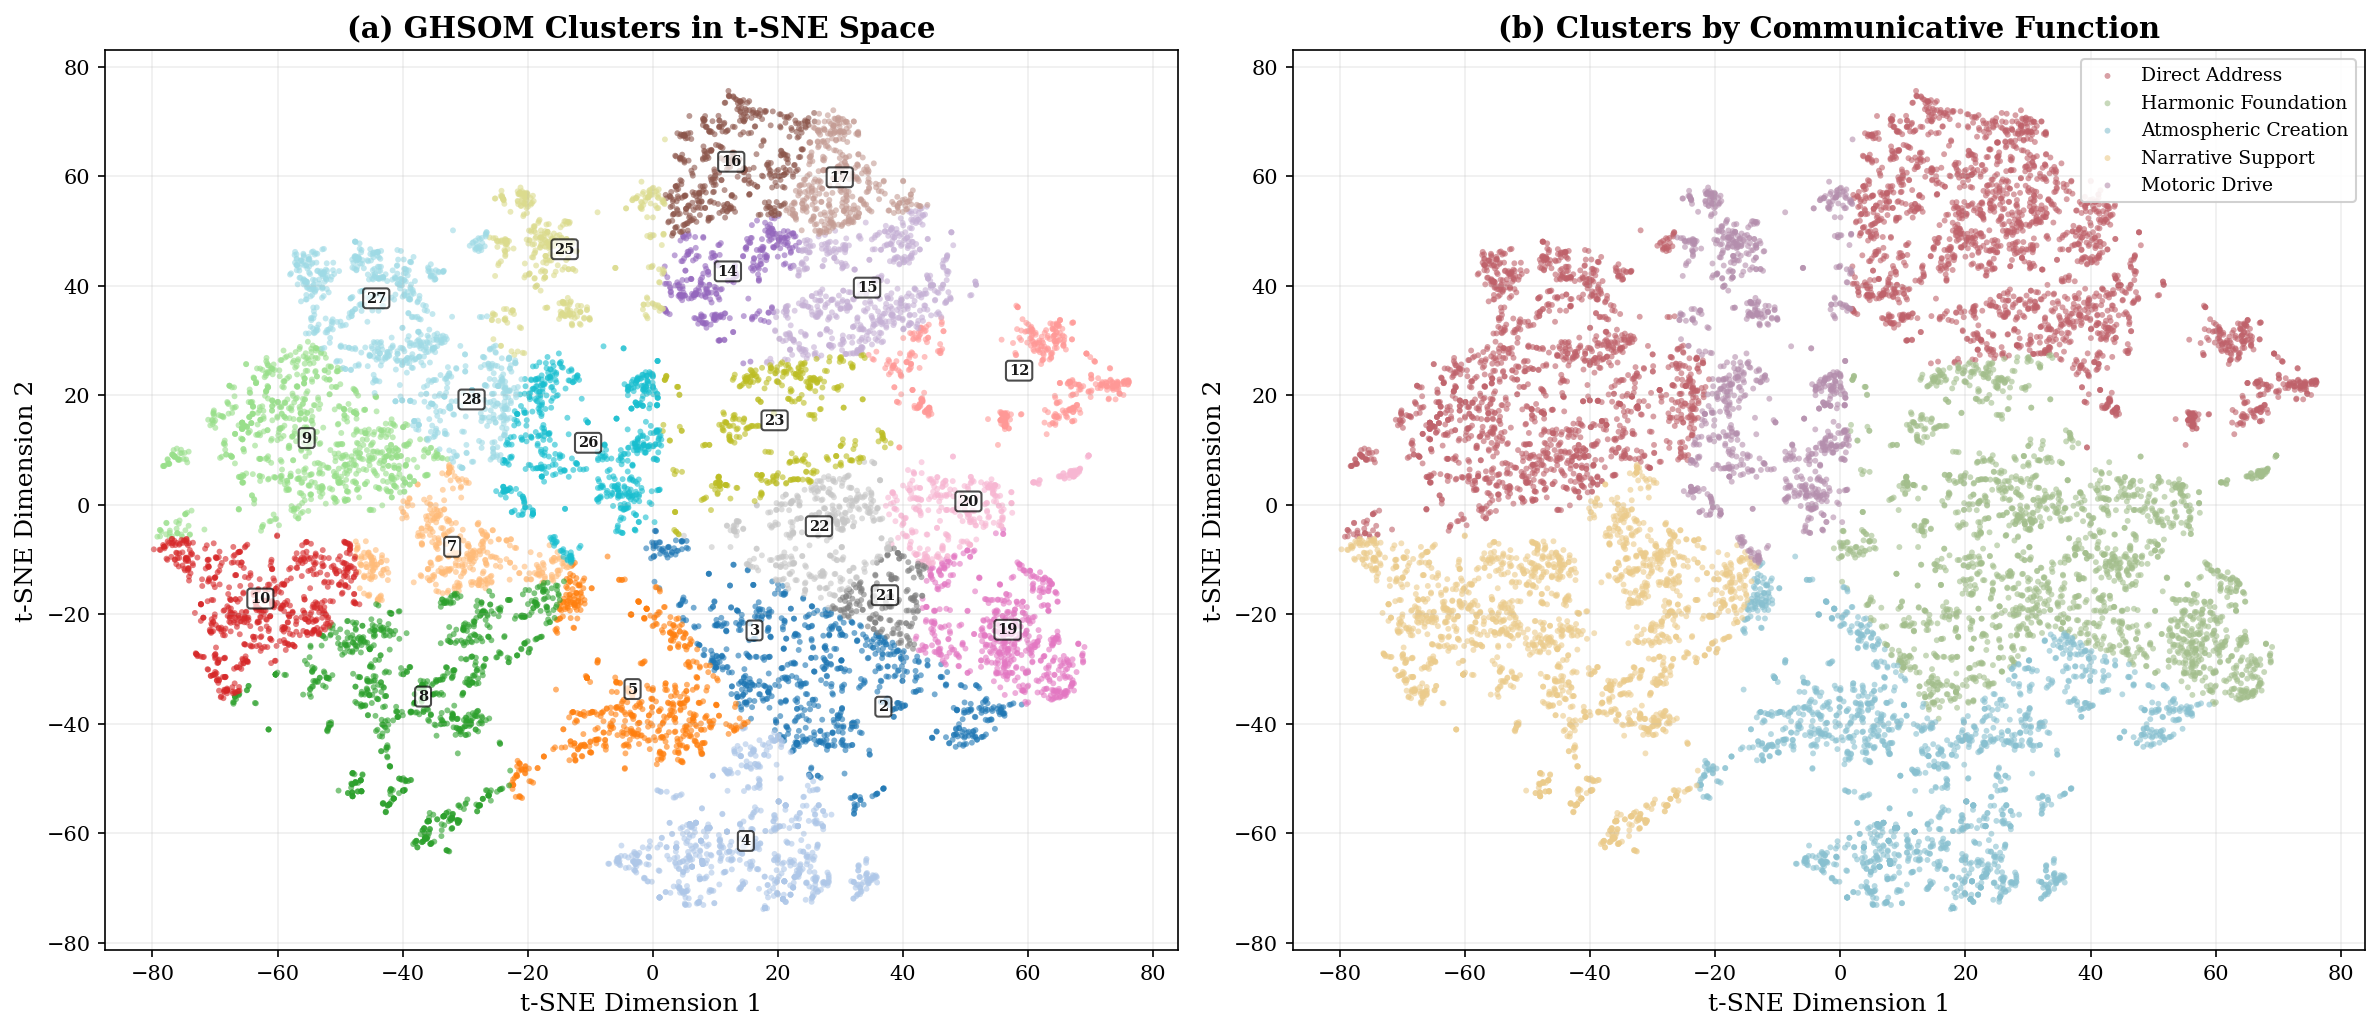


Saved: /workspace/outputs/ghsom_hierarchy_explain/fig12_tsne_ghsom_clusters.png


In [16]:
def plot_tsne_with_ghsom_clusters(data, cluster_ids, profiles_df):
    """
    Figure 12: Create publication-quality t-SNE visualization with GHSOM cluster coloring.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    unique_clusters = np.unique(cluster_ids)
    n_clusters = len(unique_clusters)
    
    # Left: Color by cluster ID
    ax = axes[0]
    cmap = plt.cm.get_cmap('tab20', n_clusters)
    
    for i, cluster_id in enumerate(unique_clusters):
        mask = cluster_ids == cluster_id
        ax.scatter(data[mask, 0], data[mask, 1], 
                  c=[cmap(i)], label=f'C{int(cluster_id)}',
                  s=8, alpha=0.6, edgecolors='none', rasterized=True)
    
    ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax.set_title('(a) GHSOM Clusters in t-SNE Space', fontweight='bold', fontsize=14)
    ax.grid(True, alpha=0.2)
    
    # Add cluster centroids with labels
    for cluster_id in unique_clusters:
        mask = cluster_ids == cluster_id
        centroid = data[mask].mean(axis=0)
        ax.annotate(f'{int(cluster_id)}', centroid, fontsize=7, ha='center', 
                   fontweight='bold', alpha=0.9,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    # Right: Color by communicative function
    ax = axes[1]
    function_colors = {
        'Direct Address': COLORS['highlight'],
        'Harmonic Foundation': COLORS['level_2'],
        'Atmospheric Creation': COLORS['level_1'],
        'Narrative Support': COLORS['secondary'],
        'Motoric Drive': COLORS['accent']
    }
    
    cluster_to_function = dict(zip(profiles_df['cluster_id'], profiles_df['communicative_function']))
    
    for func, color in function_colors.items():
        func_clusters = [c for c, f in cluster_to_function.items() if f == func]
        mask = np.isin(cluster_ids, func_clusters)
        if mask.sum() > 0:
            ax.scatter(data[mask, 0], data[mask, 1], c=color, label=func,
                      s=8, alpha=0.6, edgecolors='none', rasterized=True)
    
    ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax.set_title('(b) Clusters by Communicative Function', fontweight='bold', fontsize=14)
    ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
    ax.grid(True, alpha=0.2)
    
    plt.tight_layout()
    fig.savefig(OUTPUT_DIR / "fig12_tsne_ghsom_clusters.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

fig_tsne = plot_tsne_with_ghsom_clusters(data, cluster_ids, cluster_profiles)
print(f"\nSaved: {OUTPUT_DIR / 'fig12_tsne_ghsom_clusters.png'}")

**Figure 12: GHSOM Clusters in t-SNE Space.** (a) All 22 clusters shown with distinct colors, cluster IDs labeled at centroids. The spatial organization reveals how GHSOM partitions the feature space, with nearby clusters sharing similar musical characteristics. (b) Same data colored by communicative function, revealing how different musical "modes of address" (Direct Address, Harmonic Foundation, Atmospheric Creation, etc.) occupy distinct regions of the feature space. This visualization demonstrates that GHSOM captures meaningful musical semantics.

## 11. GHSOM vs Flat SOM: Why Hierarchy Matters

GHSOM's key advantage over flat SOM is **adaptive granularity**:
- Regions with high variance get more detailed subdivision
- Homogeneous regions remain at coarser levels
- Result: More efficient representation with fewer total neurons

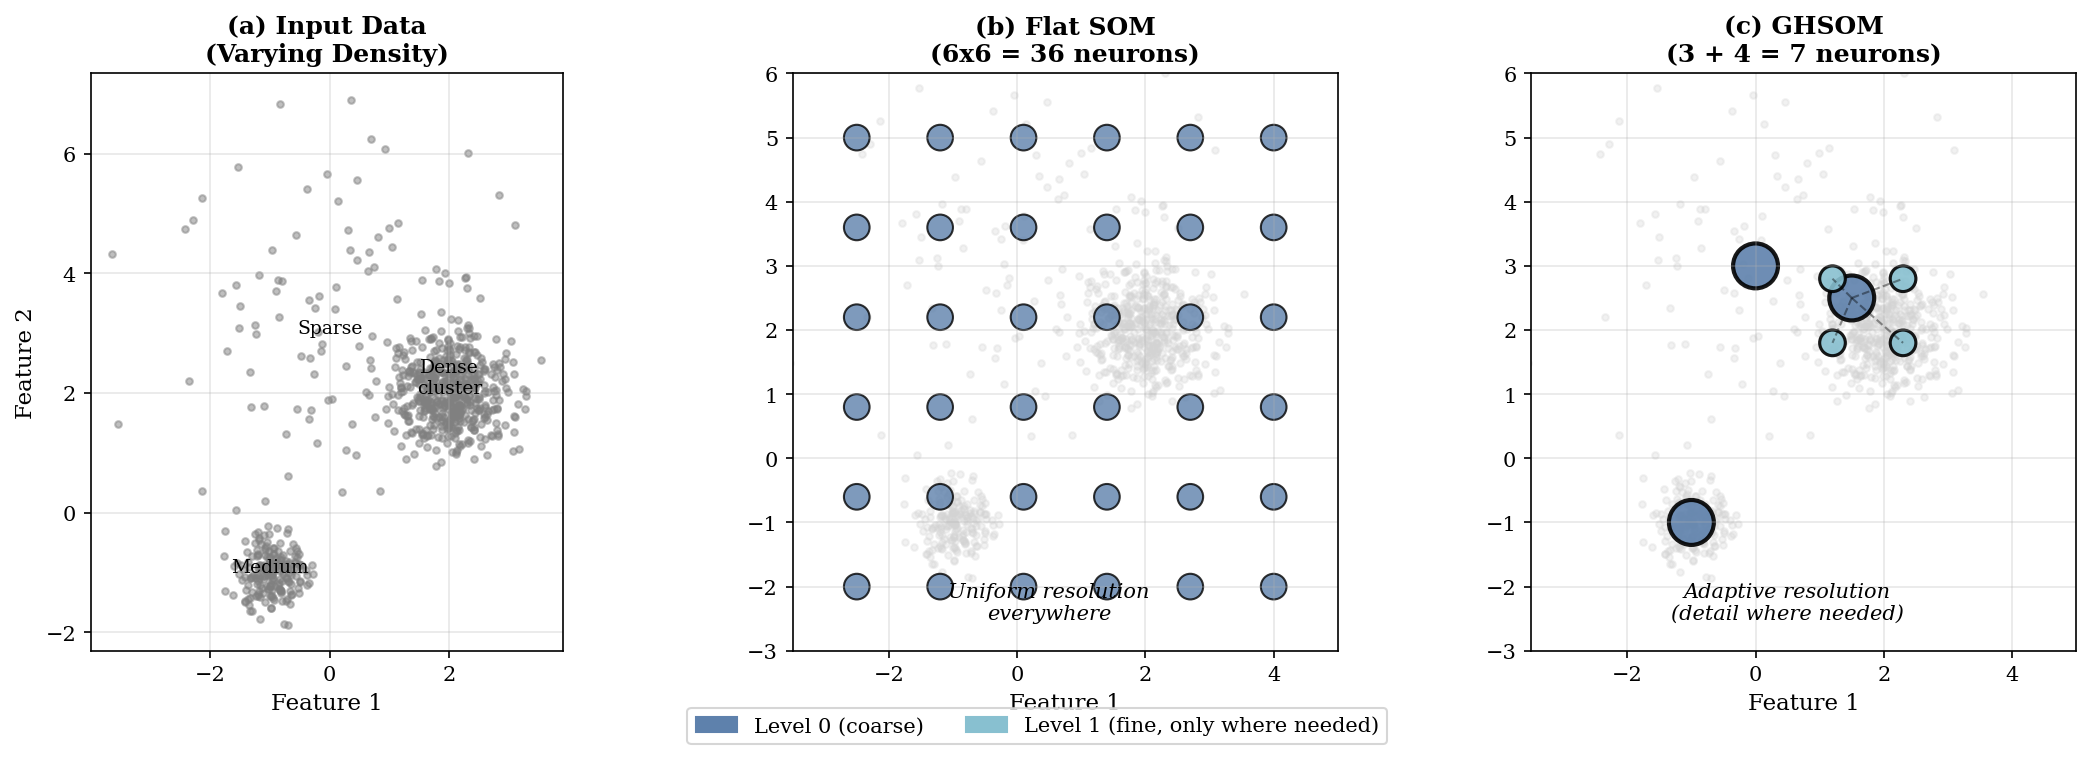


Saved: /workspace/outputs/ghsom_hierarchy_explain/fig13_ghsom_vs_som.png


In [17]:
def create_ghsom_vs_som_comparison():
    """
    Figure 13: Create conceptual comparison between flat SOM and GHSOM.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Panel 1: Data distribution (conceptual)
    ax = axes[0]
    np.random.seed(42)
    # Create data with varying density
    cluster1 = np.random.randn(500, 2) * 0.5 + [2, 2]  # Dense cluster
    cluster2 = np.random.randn(200, 2) * 0.3 + [-1, -1]  # Medium cluster
    cluster3 = np.random.randn(100, 2) * 1.5 + [0, 3]  # Sparse cluster
    demo_data = np.vstack([cluster1, cluster2, cluster3])
    
    ax.scatter(demo_data[:, 0], demo_data[:, 1], c='gray', s=10, alpha=0.5)
    ax.set_title('(a) Input Data\n(Varying Density)', fontweight='bold', fontsize=12)
    ax.set_xlabel('Feature 1', fontsize=11)
    ax.set_ylabel('Feature 2', fontsize=11)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Annotate clusters
    ax.annotate('Dense\ncluster', xy=(2, 2), fontsize=9, ha='center')
    ax.annotate('Medium', xy=(-1, -1), fontsize=9, ha='center')
    ax.annotate('Sparse', xy=(0, 3), fontsize=9, ha='center')
    
    # Panel 2: Flat SOM
    ax = axes[1]
    ax.scatter(demo_data[:, 0], demo_data[:, 1], c='lightgray', s=10, alpha=0.3)
    # Draw uniform 6x6 grid
    for i in np.linspace(-2.5, 4, 6):
        for j in np.linspace(-2, 5, 6):
            circle = plt.Circle((i, j), 0.2, color=COLORS['level_0'], 
                               ec='black', lw=1, alpha=0.8)
            ax.add_patch(circle)
    ax.set_title('(b) Flat SOM\n(6x6 = 36 neurons)', fontweight='bold', fontsize=12)
    ax.set_xlabel('Feature 1', fontsize=11)
    ax.set_xlim(-3.5, 5)
    ax.set_ylim(-3, 6)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.text(0.5, -2.5, "Uniform resolution\neverywhere", ha='center', fontsize=10, style='italic')
    
    # Panel 3: GHSOM
    ax = axes[2]
    ax.scatter(demo_data[:, 0], demo_data[:, 1], c='lightgray', s=10, alpha=0.3)
    
    # Coarse level (level 0) - 3 neurons
    level0_positions = [(-1, -1), (1.5, 2.5), (0, 3)]
    for pos in level0_positions:
        circle = plt.Circle(pos, 0.35, color=COLORS['level_0'], 
                           ec='black', lw=2, alpha=0.9)
        ax.add_patch(circle)
    
    # Detailed level for dense region (level 1) - 4 neurons
    level1_positions = [(1.2, 1.8), (2.3, 1.8), (1.2, 2.8), (2.3, 2.8)]
    for pos in level1_positions:
        circle = plt.Circle(pos, 0.2, color=COLORS['level_1'], 
                           ec='black', lw=1.5, alpha=0.9)
        ax.add_patch(circle)
    
    # Connect parent to children
    parent_pos = (1.5, 2.5)
    for child_pos in level1_positions:
        ax.plot([parent_pos[0], child_pos[0]], [parent_pos[1], child_pos[1]], 
               'k--', alpha=0.4, lw=1)
    
    ax.set_title('(c) GHSOM\n(3 + 4 = 7 neurons)', fontweight='bold', fontsize=12)
    ax.set_xlabel('Feature 1', fontsize=11)
    ax.set_xlim(-3.5, 5)
    ax.set_ylim(-3, 6)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.text(0.5, -2.5, "Adaptive resolution\n(detail where needed)", 
           ha='center', fontsize=10, style='italic')
    
    # Add legend
    legend_elements = [
        mpatches.Patch(color=COLORS['level_0'], label='Level 0 (coarse)'),
        mpatches.Patch(color=COLORS['level_1'], label='Level 1 (fine, only where needed)'),
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=2, 
               bbox_to_anchor=(0.5, -0.02), frameon=True, fontsize=10)
    
    plt.tight_layout()
    fig.savefig(OUTPUT_DIR / "fig13_ghsom_vs_som.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

fig_comparison = create_ghsom_vs_som_comparison()
print(f"\nSaved: {OUTPUT_DIR / 'fig13_ghsom_vs_som.png'}")

**Figure 13: GHSOM vs Flat SOM.** (a) Example data with varying density across three clusters. (b) Flat SOM requires uniform neuron placement (36 neurons in a 6x6 grid) regardless of local data complexity. (c) GHSOM uses only 7 neurons total, adding hierarchical detail (child map with 4 neurons) only in the high-density region. GHSOM achieves comparable or better representation quality with approximately 5x fewer neurons, while providing interpretable hierarchical organization.

## 12. Summary and Conclusions

### Key Takeaways

1. **GHSOM creates adaptive hierarchies** that match data complexity
2. **Parameters $\tau_1$ and $\tau_2$** control breadth and depth of the hierarchy
3. **BMU routing** provides interpretable paths from root to cluster
4. **Cluster quality metrics** validate the learned structure
5. **Semantic profiles** enable meaningful interpretation of clusters

In [ ]:
# Generate summary
print("=" * 80)
print("GHSOM HIERARCHY EXPLANATION NOTEBOOK - COMPLETE")
print("=" * 80)

print(f"\nModel Statistics:")
print(f"  Total Samples: {len(data):,}")
print(f"  Hierarchy Depth: {int(model_metrics['ghsom_depth'])} levels")
print(f"  Total Maps: {int(model_metrics['num_maps'])}")
print(f"  Total Neurons: {int(model_metrics['num_neurons'])}")
print(f"  Leaf Clusters: {int(model_metrics['num_clusters'])}")
print(f"  Silhouette Score: {silhouette:.4f}")
print(f"  Davies-Bouldin Index: {db_score:.4f}")

print(f"\nOutput directory: {OUTPUT_DIR}")
print(f"\nGenerated figures:")
for f in sorted(OUTPUT_DIR.glob("*.png")):
    print(f"  - {f.name}")
for f in sorted(OUTPUT_DIR.glob("*.html")):
    print(f"  - {f.name}")

print("\n" + "=" * 80)
print("=" * 80)

GHSOM HIERARCHY EXPLANATION NOTEBOOK - COMPLETE

Model Statistics:
  Total Samples: 11,143
  Hierarchy Depth: 3 levels
  Total Maps: 7
  Total Neurons: 28
  Leaf Clusters: 22
  Silhouette Score: 0.3063
  Davies-Bouldin Index: 0.8624

Output directory: /workspace/outputs/ghsom_hierarchy_explain

Generated figures:
  - fig10_cluster_quality.png
  - fig11_cluster_semantic_profiles.png
  - fig12_tsne_ghsom_clusters.png
  - fig13_ghsom_vs_som.png
  - fig1_ghsom_growth_concept.png
  - fig2_ghsom_hierarchy_tree.png
  - fig4_bmu_routing_sample0.png
  - fig4_bmu_routing_sample10000.png
  - fig4_bmu_routing_sample5000.png
  - fig5_node_position_root.png
  - fig6_weight_heatmap_root.png
  - fig7_umatrix_root.png
  - fig8_activation_maps.png
  - fig9_cluster_distribution.png
  - fig3_hierarchy_treemap.html

Ready for AAMAS conference paper and presentation!


---

## Appendix: Figure Summary for Paper

| Figure | Filename | Description | Suggested Location |
|--------|----------|-------------|-------------------|
| Fig. 1 | `fig1_ghsom_growth_concept.png` | GHSOM growth process (4 stages) | Methods section |
| Fig. 2 | `fig2_ghsom_hierarchy_tree.png` | Full hierarchy tree structure | Results section |
| Fig. 3 | `fig3_hierarchy_treemap.html` | Interactive treemap (supplementary) | Appendix |
| Fig. 4 | `fig4_bmu_routing_*.png` | BMU routing examples | Methods section |
| Fig. 5 | `fig5_node_position_*.png` | Node context visualization | Appendix |
| Fig. 6 | `fig6_weight_heatmap_root.png` | Weight vectors | Appendix |
| Fig. 7 | `fig7_umatrix_root.png` | U-Matrix | Appendix |
| Fig. 8 | `fig8_activation_maps.png` | Activation patterns | Appendix |
| Fig. 9 | `fig9_cluster_distribution.png` | Cluster size distribution | Results section |
| Fig. 10 | `fig10_cluster_quality.png` | Quality metrics | Results section |
| Fig. 11 | `fig11_cluster_semantic_profiles.png` | Semantic profiles (6-panel) | Results section |
| Fig. 12 | `fig12_tsne_ghsom_clusters.png` | t-SNE visualization | Results section |
| Fig. 13 | `fig13_ghsom_vs_som.png` | GHSOM vs SOM comparison | Discussion section |